In April 2010, Iceland's Eyjafjallajökull volcano erupted, causing significant disruption across Europe. The eruption released a massive ash cloud into the atmosphere, which led to the closure of airspace over much of Europe for several days due to concerns about the ash damaging aircraft engines. This event stranded millions of passengers and had a considerable economic impact on the aviation industry. The eruption also highlighted the need for better volcanic monitoring and ash cloud tracking to mitigate similar disruptions in the future.  
In this report, I'll study the meteorological effect that the eruption had on Iceland's climate.

# Preparing for Analysis

## Package installation and import

In [1]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install scikit-learn
# %pip install altair
# %pip install openmeteo_requests
# %pip install requests_cache
# %pip install retry_requests
# %pip install pyet

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request
import ssl
from scipy.stats import genextreme
import os
import pyet
import altair as alt
from scipy.stats import genextreme
import matplotlib.dates as mdates

In [3]:
pwd = os.getcwd()
pwd

'/Users/ranavner/Desktop/Studies/Third Year/surface_hydrology/final_project'

In [4]:
# let's create a directory to store the data and the outputs
data_dir = os.path.join(pwd, 'data')
output_dir = os.path.join(pwd, 'output')
penman_dir = os.path.join(pwd, 'output', 'penman_output')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(penman_dir):
    os.makedirs(penman_dir)



## Data collection and organization

### Download Hourly Data from Open-Meteo API

In [5]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
def download_hourly_data(year):
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
		"latitude": 64.12479889624187,
		"longitude": -21.907882974361257,
		"start_date": f"{year}-01-01",
		"end_date": f"{year}-12-31",
		"hourly": ["temperature_2m", "relative_humidity_2m", "vapour_pressure_deficit", "wind_speed_10m", "soil_temperature_0_to_7cm", "et0_fao_evapotranspiration"],
		"daily": "daylight_duration",
		"wind_speed_unit": "ms"
	}
	responses = openmeteo.weather_api(url, params=params)

	# Process first location. Add a for-loop for multiple locations or weather models
	response = responses[0]
	# print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
	# print(f"Elevation {response.Elevation()} m asl")
	# print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
	# print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

	# Process hourly data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
	hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
	hourly_et0_fao_evapotranspiration = hourly.Variables(2).ValuesAsNumpy()
	hourly_vapour_pressure_deficit = hourly.Variables(2).ValuesAsNumpy()
	hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
	hourly_soil_temperature_0_to_7cm = hourly.Variables(4).ValuesAsNumpy()

	hourly_data = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}
	hourly_data["temperature_2m"] = hourly_temperature_2m # to kelvin
	hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
	hourly_data["et0_fao_evapotranspiration"] = hourly_et0_fao_evapotranspiration
	hourly_data["vapour_pressure_deficit"] = hourly_vapour_pressure_deficit
	hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
	hourly_data["soil_temperature_0_to_7cm"] = hourly_soil_temperature_0_to_7cm

	hourly_df = pd.DataFrame(data = hourly_data)
	hourly_df.set_index("date", inplace = True)	# Set the date as index
	return hourly_df

### Download Daily and Monthly Data from NOAA

In [6]:
ssl._create_default_https_context = ssl._create_stdlib_context

def download_data(station_name, station_code):
    url_daily = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    url_monthly = 'https://www.ncei.noaa.gov/data/gsom/access/'
    # download daily data 
    urllib.request.urlretrieve(url_daily + station_code + '.csv', os.path.join(pwd, 'data', station_name + '_daily.csv'))
    # download monthly data
    urllib.request.urlretrieve(url_monthly + station_code + '.csv', os.path.join(pwd, 'data', station_name + '_monthly.csv'))

In [7]:
download_data('Reykjavik', 'IC000004030')

### Creating Daily and Monthly DataFrames

In [8]:
# creating dataframes from the data we downloded
df_monthly = pd.read_csv(os.path.join('data', 'Reykjavik_monthly.csv'))
df_daily = pd.read_csv(os.path.join('data', 'Reykjavik_daily.csv'))

# lets convert the date column to datetime
df_monthly['DATE'] = pd.to_datetime(df_monthly['DATE'], format='%Y-%m')
df_daily['DATE'] = pd.to_datetime(df_daily['DATE'], format='%Y-%m-%d')

# setting the 'DATE' column as the index
df_monthly.set_index('DATE', inplace=True)
df_daily.set_index('DATE', inplace=True)

# daily precipitation data is in tenths of mm, lets convert it to mm
df_daily['PRCP'] = df_daily['PRCP'] / 10

# apparently the temperature is also in tenths of degrees C, lets convert it to celsius
df_daily['TMAX'] = df_daily['TMAX'] / 10
df_daily['TMIN'] = df_daily['TMIN'] / 10
df_daily['TAVG'] = df_daily['TAVG'] / 10

# let's remove the rows with missing values
df_daily = df_daily.dropna(subset=['PRCP'])# now df_daily is only the rows with precipitation data (1949-2016)
df_monthly = df_monthly.dropna(subset=['PRCP'])# now df_monthly is only the rows with temperature data (1949-2016)


# Obligatory Part

### Intra-Annual Variability of Precipitation

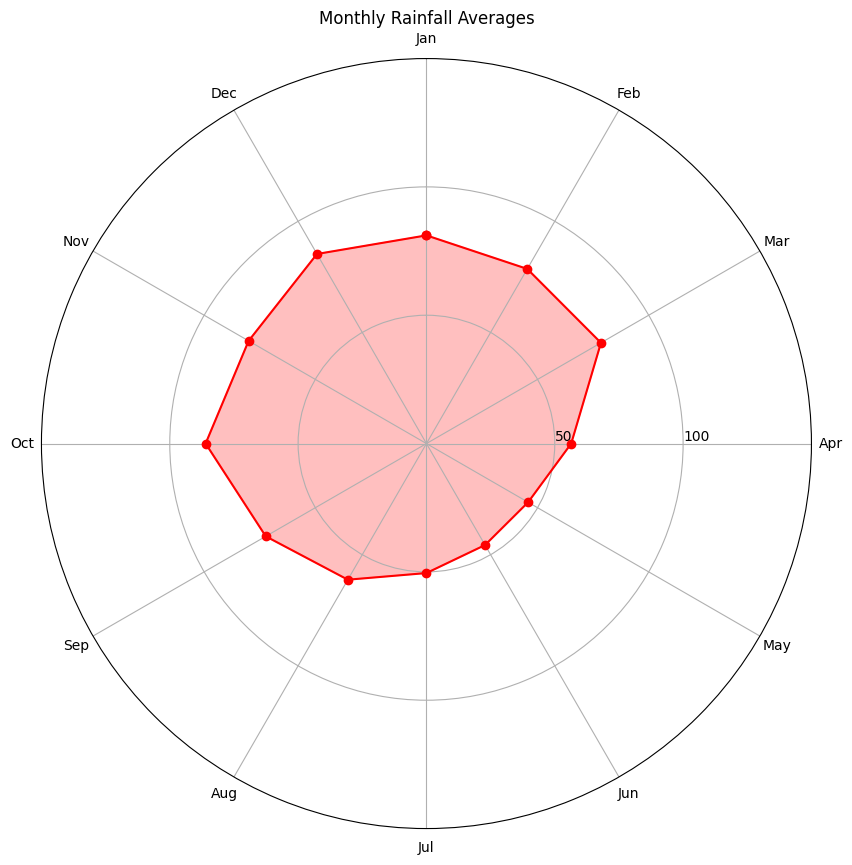

In [9]:
monthly_reykjavik = (df_monthly['PRCP']
                    .groupby(df_monthly.index.month)
                    .mean()
                    .to_frame()
                  )
fig = plt.figure(figsize=(10,10))

# radar chart
ax = fig.add_subplot(111, polar=True)     # make polar plot
ax.set_theta_zero_location("N")           # January on top ("N"orth)
ax.set_theta_direction(-1)                # clockwise direction
ax.set_rlabel_position(90)                # radial labels on the right
ax.set_rticks([50,100])                   # two radial ticks is enough
ax.set_rlim(0,150)                        # limits of r axis
angles=np.linspace(0, 2*np.pi, 12, endpoint=False)       # divide circle into 12 slices
angles=np.append(angles, angles[0])                      # close loop, otherwise lines will be open
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_thetagrids(angles[:-1] * 180/np.pi, month_names)  # relabel angles with month names

# plot reykjavik data
stats_reykjavik = np.array(monthly_reykjavik['PRCP'].values)        # get reykjavik data
stats_reykjavik = np.append(stats_reykjavik, stats_reykjavik[0])           # close loop
ax.plot(angles, stats_reykjavik, "o-", color='red', label="Reykyavik Precipitation")  # plot line
ax.fill(angles, stats_reykjavik, alpha=0.25, color='red')              # fill

ax.set_title("Monthly Rainfall Averages")

# save figure
plt.savefig("output/radar_chart_Reykjavik.png")

In [10]:
def walsh_index(df):
    m = df["PRCP"].values
    R = m.sum()
    SI = np.sum(np.abs(m-R/12)) / R
    return SI

reykjavik_index = walsh_index(monthly_reykjavik)
print("Seasonality index (Walsh and Lawler, 1981)")
print(f"Reykjavik, Iceland: {reykjavik_index:.2f}")

Seasonality index (Walsh and Lawler, 1981)
Reykjavik, Iceland: 0.20


The seasonality index of Reykjavik is 0.2, which mean that precipitation spread throughout the year, but with a definite wetter season.

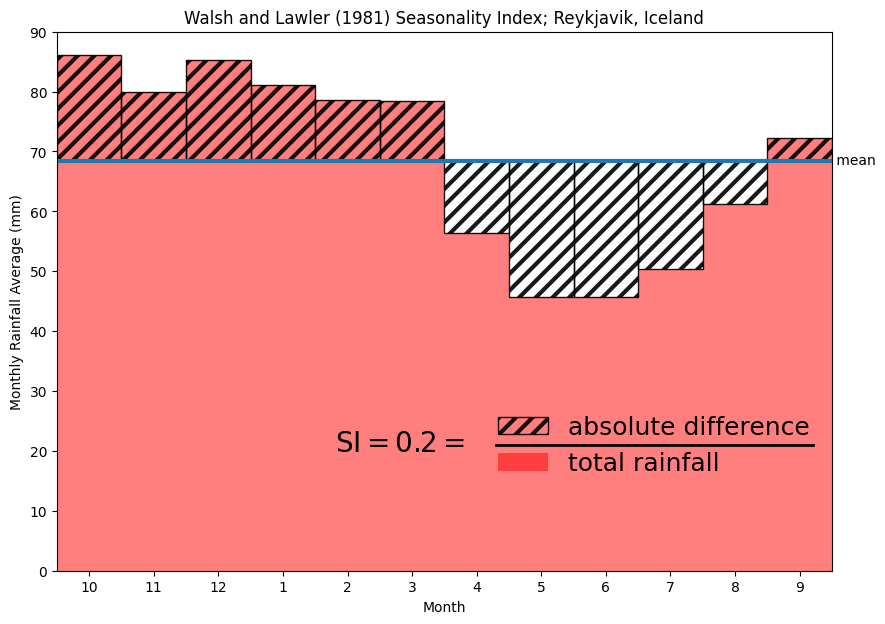

In [11]:
Nroll = 3  # number of months to roll
roll_reykjavik = np.roll(monthly_reykjavik['PRCP'], Nroll)
roll_months = np.roll(monthly_reykjavik.index, Nroll)

fig, ax = plt.subplots(figsize=(10,7))

plt.rcParams['hatch.linewidth'] = 3
xlim = [1, 13]
total_reykjavik = np.sum(roll_reykjavik)
ax.plot(xlim, [total_reykjavik/12]*2, color="tab:blue", linewidth=3)
ax.set_xlim(xlim)

shaded = roll_reykjavik - total_reykjavik/12
months = monthly_reykjavik.index
ax.bar(months, shaded,
       alpha=0.9, color="None", width=1,
       hatch="//", edgecolor='k',
       align='edge', bottom=total_reykjavik/12,
       label=f"absolute difference")

ax.bar(months, roll_reykjavik,
       alpha=0.5, color="red", width=1,
       align='edge',
       label=f"total rainfall", zorder=0)


ax.text(5.3, 20, r"SI$=0.2=$", fontsize=20)
ax.text(xlim[-1], total_reykjavik/12, " mean", va="center")
ax.plot([7.8, 12.7], [21]*2, color="black", lw=2)
# axes labels and figure title
ax.set(xlabel='Month',
       ylabel='Monthly Rainfall Average (mm)',
       title='Walsh and Lawler (1981) Seasonality Index; Reykjavik, Iceland',
       xticks=np.arange(1.5,12.6,1),
       xticklabels=roll_months,
       ylim=[0,90],
      )

plt.legend(loc='upper right', frameon=False, bbox_to_anchor=(1, 0.33),
           fontsize=18);
plt.savefig("output/seaasonality_calc.png")

### Interannual Variability of Precipitation

In [12]:
df_year = df_monthly['PRCP'].resample('YE-SEP').sum().to_frame()  # yearly frequency, anchored end of September

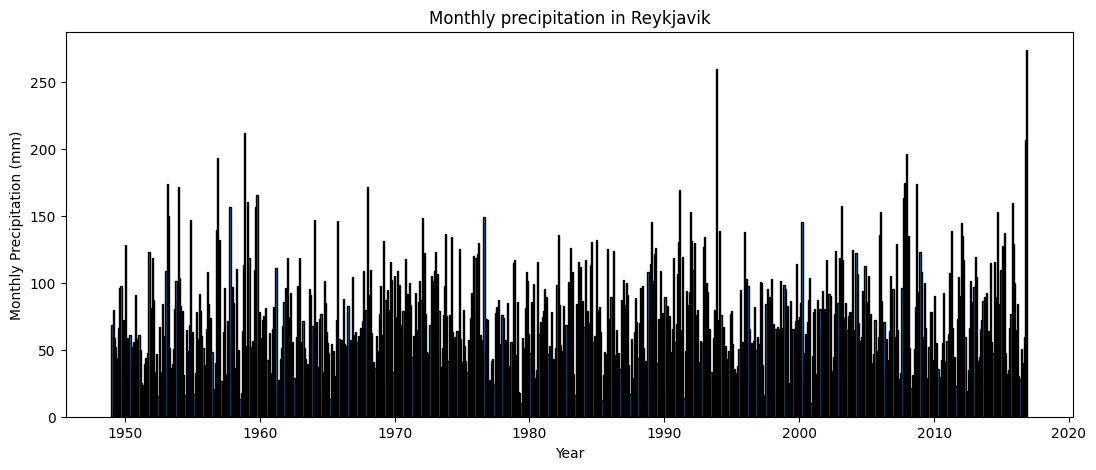

In [13]:
# creating a monthly average precipitation plot
fig, ax = plt.subplots(figsize=(13,5))

# plot precipitation
# ax.fill_between(df_monthly.index, df_monthly['PRCP'], 0, color='tab:blue')
ax.hist(df_monthly.index, weights=df_monthly['PRCP'], bins=df_monthly.index, color='tab:blue', edgecolor='black')

# adjust labels, ticks, title, etc
ax.set_title("Monthly precipitation in Reykjavik")
ax.set_xlabel('Year')
ax.set_ylabel('Monthly Precipitation (mm)')

# save figure
plt.savefig("output/monthly_precipitation.png")

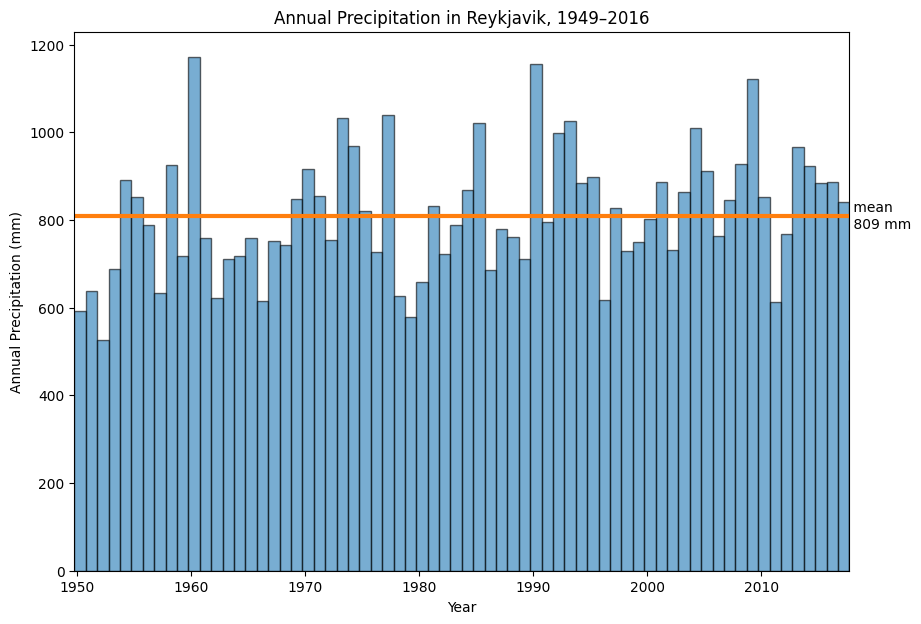

In [14]:
fig, ax = plt.subplots(figsize=(10,7))

# plot yearly precipitation
ax.bar(df_year.index, df_year['PRCP'],
       width=365, align='edge', color="tab:blue", alpha=0.6, edgecolor="black")

# plot mean
rain_mean = df_year['PRCP'].mean()
ax.plot(df_year*0 + rain_mean, linewidth=3, color="tab:orange")

# adjust labels, ticks, title, etc

ax.set(title="Annual Precipitation in Reykjavik, 1949–2016",
       xlabel="Year",
       ylabel="Annual Precipitation (mm)",
       xlim=[df_year.index[0], df_year.index[-1]]
      )

# write mean on the right
ax.text(df_year.index[-1], rain_mean, " mean\n {:.0f} mm".format(rain_mean),
        horizontalalignment="left", verticalalignment="center");

plt.savefig("output/annual_precipitation_reg.png")



In [15]:
# let's calculate the coefficient of variation for the yearly precipitation
cv = df_year['PRCP'].std() / df_year['PRCP'].mean()
print(f"The std of the annual precipitation is {df_year['PRCP'].std().round(2)} mm, CV of yearly precipitation: {cv:.2f}")



The std of the annual precipitation is 146.52 mm, CV of yearly precipitation: 0.18


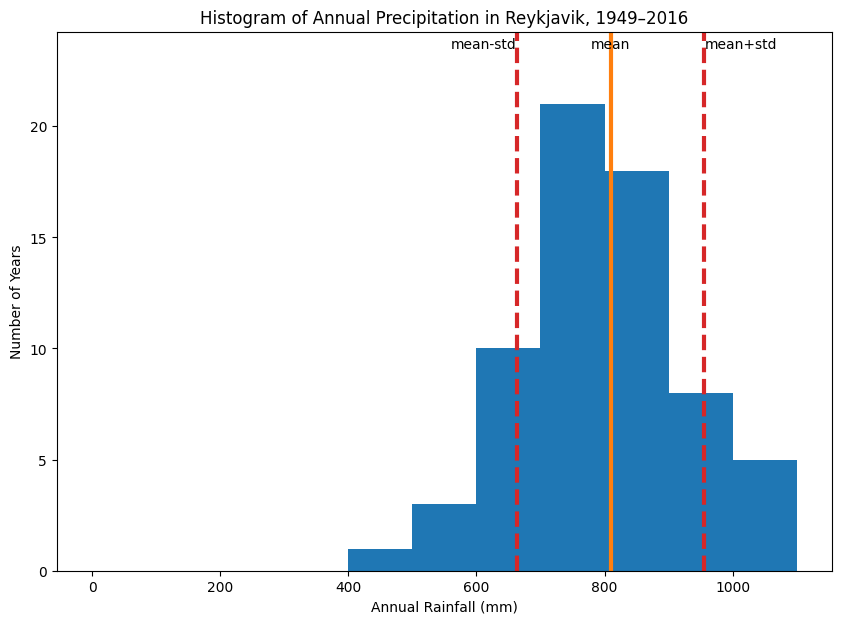

In [16]:
fig, ax = plt.subplots(figsize=(10,7))

# calculate mean and standard deviation
rain_mean = df_year['PRCP'].mean()
rain_std = df_year['PRCP'].std()

# plot histogram
b = np.arange(0, 1101, 100)  # bins from 0 to 55, width = 5
ax.hist(df_year, bins=b)

# plot vertical lines with mean, std, etc
ylim = np.array(ax.get_ylim())
ylim[1] = ylim[1]*1.1
ax.plot([rain_mean]*2, ylim, linewidth=3, color="tab:orange")
ax.plot([rain_mean+rain_std]*2, ylim, linewidth=3, linestyle="--", color="tab:red")
ax.plot([rain_mean-rain_std]*2, ylim, linewidth=3, linestyle="--", color="tab:red")
ax.set_ylim(ylim)

# write mean, std, etc
ax.text(rain_mean, ylim[1]*0.99, "mean",
        horizontalalignment="center",
        verticalalignment="top",
        )
ax.text(rain_mean+rain_std, ylim[1]*0.99, "mean+std",
        horizontalalignment="left",
        verticalalignment="top",
        )
ax.text(rain_mean-rain_std, ylim[1]*0.99, "mean-std",
        horizontalalignment="right",
        verticalalignment="top",
        )

# adjust labels, ticks, title, limits, etc
ax.set(title="Histogram of Annual Precipitation in Reykjavik, 1949–2016",
       xlabel="Annual Rainfall (mm)",
       ylabel="Number of Years"
       );


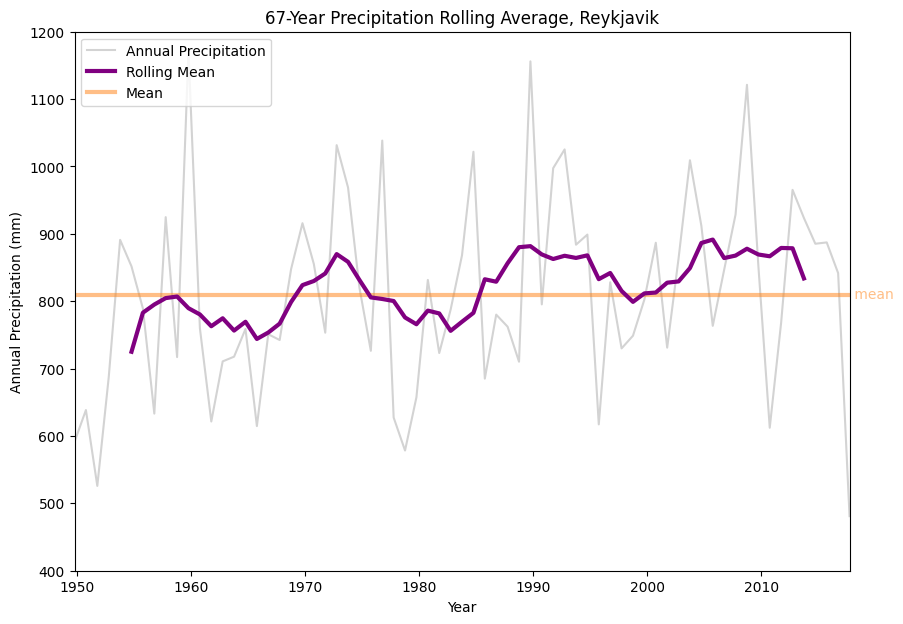

In [17]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(df_year['PRCP'], color="lightgray")

# plot rolling mean
rolling_mean = df_year.rolling(window=10, center=True).mean()
ax.plot(rolling_mean, linewidth=3, color="purple", zorder=5)


# plot mean
ax.plot(df_year*0 + rain_mean, linewidth=3, color="tab:orange", alpha=0.5)
ax.text(df_year.index[-1], rain_mean, " mean".format(rain_mean),
        horizontalalignment="left", verticalalignment="center",
        color="tab:orange", alpha=0.5);

ax.set(title="67-Year Precipitation Rolling Average, Reykjavik",
       xlabel="Year",
       ylabel="Annual Precipitation (mm)",
       ylim=[400, 1200],
       xlim=[df_year.index[0], df_year.index[-1]]
      )
plt.legend(['Annual Precipitation', 'Rolling Mean', 'Mean'], loc='upper left', frameon=True);
plt.savefig("output/67_years_precipitation.png")


### Return Period

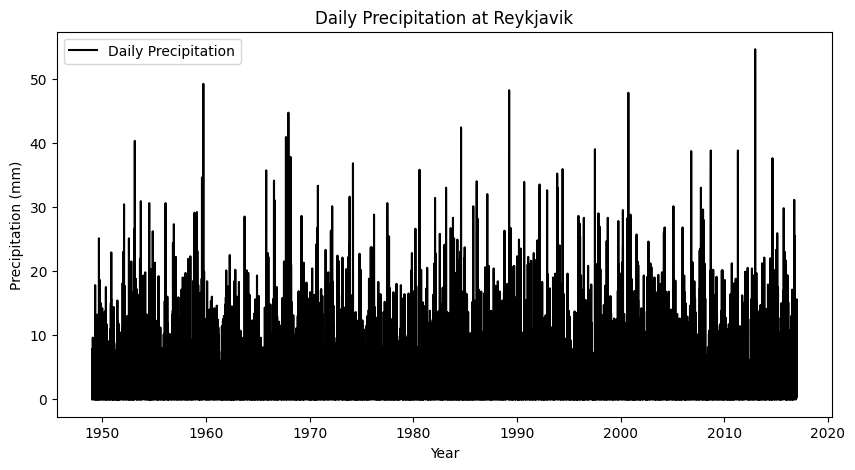

In [18]:
# lets start by ploting the daily precipitation data
plt.figure(figsize=(10, 5))
plt.plot(df_daily['PRCP'], label='Daily Precipitation', color='black')
plt.title('Daily Precipitation at Reykjavik')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.savefig("output/daily_precipitation_simple.png")
plt.show()


The maximum daily precipitation in Reykyavik was 54.6 mm on 2012-12-29


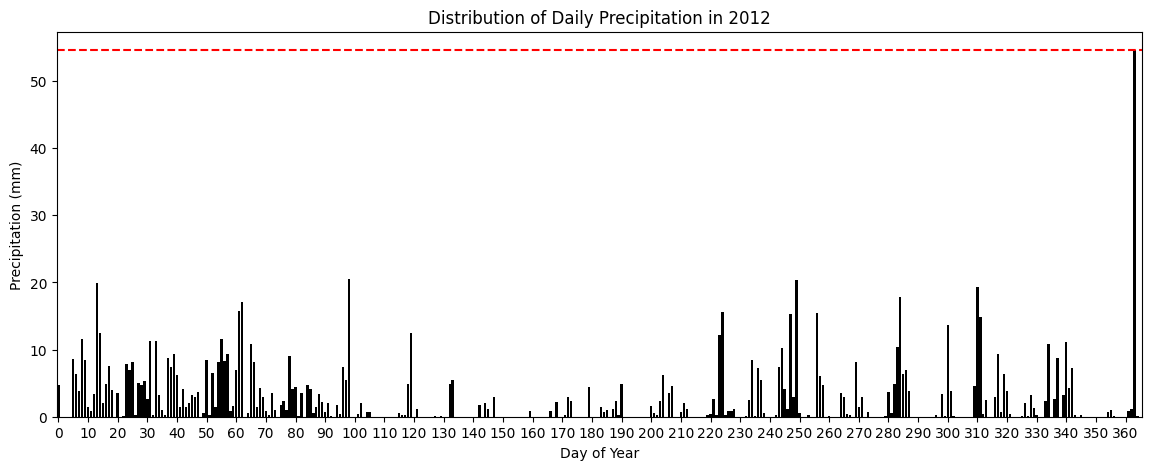

In [19]:
# let's focus on the most extreme events
day_of_max_prcp = df_daily['PRCP'].idxmax().date()
max_prcp = df_daily['PRCP'].max()
print(f'The maximum daily precipitation in Reykyavik was {max_prcp} mm on {day_of_max_prcp}')

# lets plot the distribution of daily precipitation of 2012
df_max_day_prcp = df_daily[df_daily.index.year == 2012]
doy = 364

plt.figure(figsize=(14, 5))
sns.barplot(x=df_max_day_prcp.index, y=df_max_day_prcp['PRCP'], color='black', )
plt.title('Distribution of Daily Precipitation in 2012')
plt.xlabel('Day of Year')
plt.ylabel('Precipitation (mm)')
# lets make the x axis labels doy (day of year)
plt.xticks(np.arange(0, 370, 10), labels=np.arange(0, 370, 10))

# add a line for the maximum precipitation
plt.axhline(y=max_prcp, color='red', linestyle='--', label='Max Precipitation')
plt.savefig("output/daily_precipitation_2012.png")
plt.show()

Let's see how rare those events are, so we'll calculate the return period time.

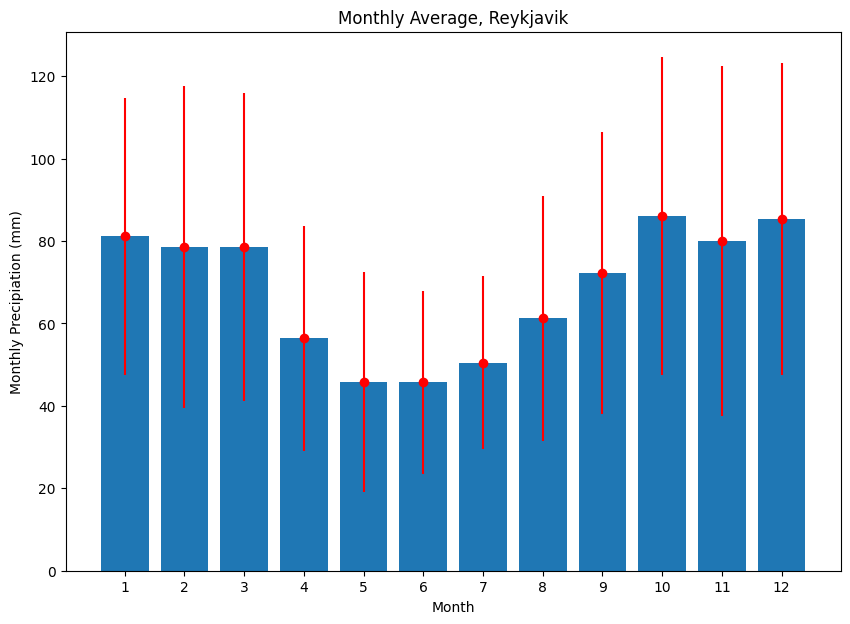

In [20]:
# let's see the monthly average precipitation   
df_daily_gbmonth = df_daily['PRCP'].resample('ME').sum().to_frame()
df_month_avg = (df_daily_gbmonth['PRCP']
                  .groupby(df_daily_gbmonth.index.month)
                  .mean()
                  .to_frame()
               )
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(df_month_avg.index, df_month_avg['PRCP'])
ax.set(xlabel="Month",
       ylabel="Monthly Precipiation (mm)",
       title="Monthly Average, Reykjavik",
       xticks=np.arange(1,13));

# lets add the sandart deviation
df_month_std = (df_daily_gbmonth['PRCP']
                  .groupby(df_daily_gbmonth.index.month)
                  .std()
                  .to_frame()
               )
ax.errorbar(df_month_avg.index, df_month_avg['PRCP'], yerr=df_month_std['PRCP'], fmt='o', color='red')
plt.show()

The Hydrological year in Reykjavik starts in October 1st, since Iceland is a country where much of the precipitation is snowfall, the total annual precipitation reflects the winter snow accumulation as well as summer rainfall.
To be more clear, the winter snowfall is supposed to be in the same hydrological year as it melts, and because the snowfall in Iceland starts around October, and melts in the summer, then the hydrological year starts in October and ends in September, when the snow stops melting due to the setting temperatures.

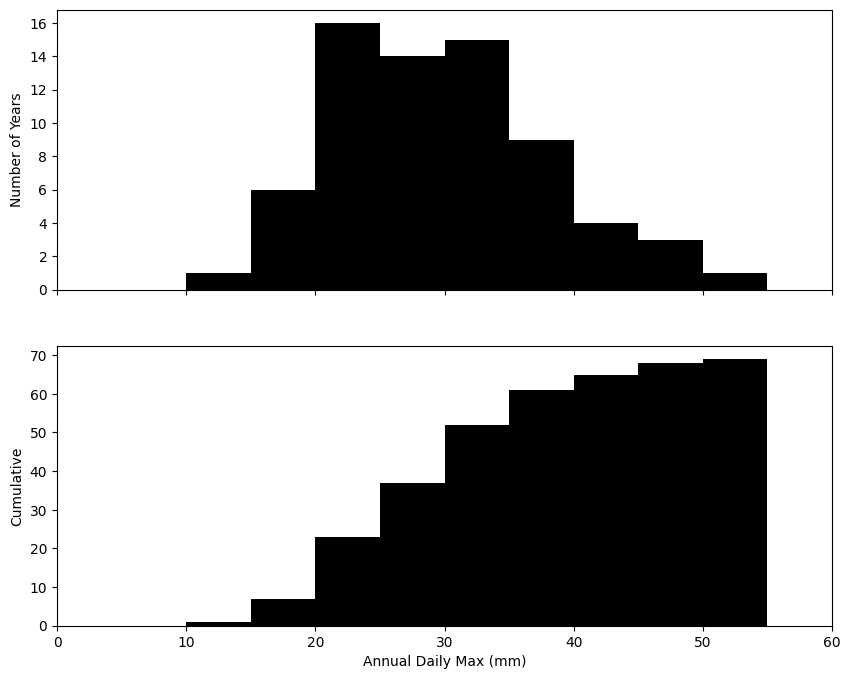

In [21]:
max_annual = (df_daily['PRCP'].resample('YE-SEP')
                        .max()
                        .to_frame()
             )


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True)

h=max_annual['PRCP'].values

bins=np.arange(0,60,5)
ax1.hist(h, bins=bins, color='black')
ax2.hist(h, bins=bins, cumulative=1, color='black')

ax1.set(ylabel="Number of Years")
ax2.set(xlabel="Annual Daily Max (mm)",
        ylabel="Cumulative",
        xlim=[0,60]);

plt.savefig("output/cumulative.png")

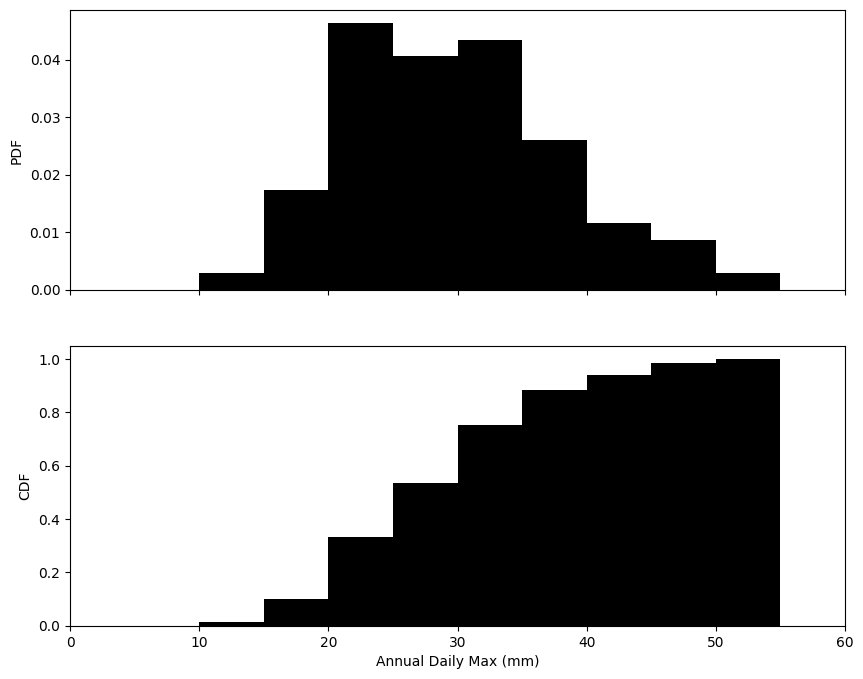

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True)

ax1.hist(h, bins=bins, density=True, color='black')
ax2.hist(h, bins=bins, cumulative=1, density=True, color='black')

ax1.set(ylabel="PDF")
ax2.set(xlabel="Annual Daily Max (mm)",
        ylabel="CDF",
        xlim=[0,60]
        );

plt.savefig("output/pdf_cdf.png")

In [23]:
def plot_pdf_and_survival(survival):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True)

    ax1.hist(h, bins=bins, density=True, histtype='stepfilled', alpha=0.2)
    ax2.hist(h, bins=bins, density=True, histtype='stepfilled', alpha=0.2, cumulative=-1)

    params = genextreme.fit(h)
    rain_max = 60.0
    rain = np.arange(0,rain_max)
    pdf = genextreme(c=params[0], loc=params[1], scale=params[2]).pdf
    cdf = genextreme(c=params[0], loc=params[1], scale=params[2]).cdf
    ax1.plot(rain, pdf(rain), 'r-', lw=5, alpha=0.6, clip_on=False, color='purple')
    ax2.plot(rain, 1-cdf(rain), 'r-', lw=5, alpha=0.6, clip_on=False, color='purple')
    ax1.set(ylabel="Probability Density")
    ax2.set(xlabel="Annual Daily Max (mm)",
            ylabel="Survival = 1-cdf",
            xlim=[0,60])

    # survival = 0.20
    threshold = genextreme(c=params[0], loc=params[1], scale=params[2]).ppf(1-survival)
    xfill = np.linspace(threshold, rain_max, 90)
    ax1.fill_between(xfill, pdf(xfill), color='None', hatch="//",edgecolor='k', label=f"{survival:.0%} of the area")
    ax2.plot([0, threshold, threshold], [survival, survival ,0], color="purple", ls=":")
    ax2.text(20, survival, "{:.0f}%".format(100*survival), ha="left", va="bottom", fontsize=16)

    ax1.set(title=("We'll wait " +
                r"$\bf{" + "onֿֿ\\;average" + "}$ "+
                f"({survival:.0%})" +
                r"$^{-1}=$" +
                f"({survival:.2f})" +
                r"$^{-1}=$" +
                f" {1/survival:.0f} years\nfor a yearly maximum above {threshold:.0f} mm"
                )
        )
    ax1.legend(loc="upper right", frameon=False)
    plt.savefig(f"output/survival_{survival}.png")

/var/folders/55/m3ddmhsx3qbf91b3147_ryth0000gn/T/ipykernel_69289/168264660.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(rain, pdf(rain), 'r-', lw=5, alpha=0.6, clip_on=False, color='purple')
/var/folders/55/m3ddmhsx3qbf91b3147_ryth0000gn/T/ipykernel_69289/168264660.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(rain, 1-cdf(rain), 'r-', lw=5, alpha=0.6, clip_on=False, color='purple')


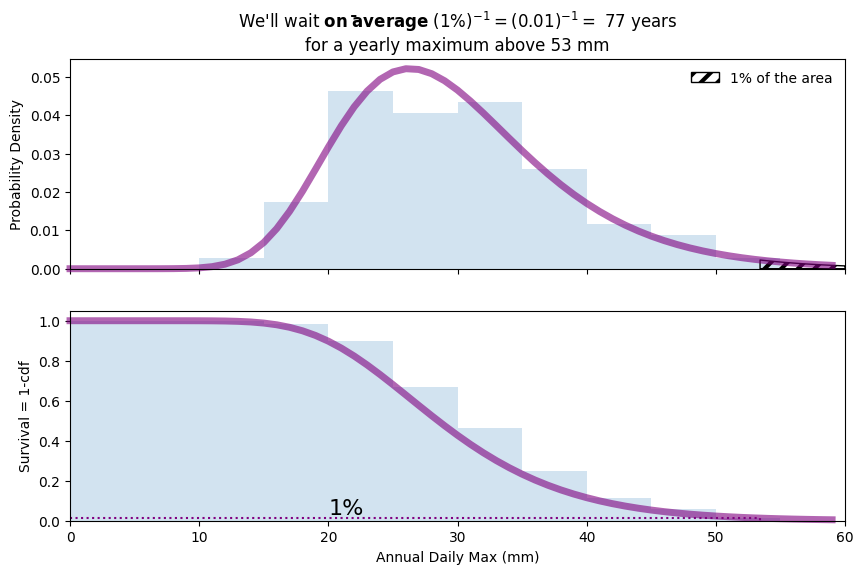

In [24]:
plot_pdf_and_survival(0.013)

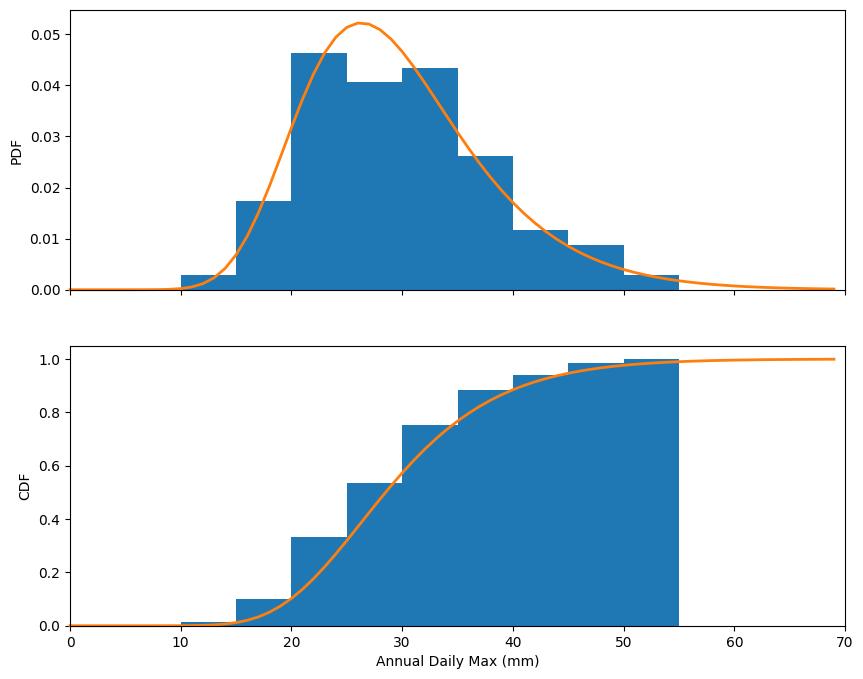

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True)

ax1.hist(h, bins=bins, density=True)
ax2.hist(h, bins=bins, cumulative=1, density=True)

params = genextreme.fit(h)
rain_max = 70.0
rain = np.arange(0,rain_max)
pdf = genextreme(c=params[0], loc=params[1], scale=params[2]).pdf
cdf = genextreme(c=params[0], loc=params[1], scale=params[2]).cdf
ax1.plot(rain, pdf(rain), color='tab:orange', clip_on=False, lw=2)
ax2.plot(rain, cdf(rain), color='tab:orange', clip_on=False, lw=2)

ax1.set(ylabel="PDF")
ax2.set(xlabel="Annual Daily Max (mm)",
        ylabel="CDF",
        xlim=[0,70]
        );

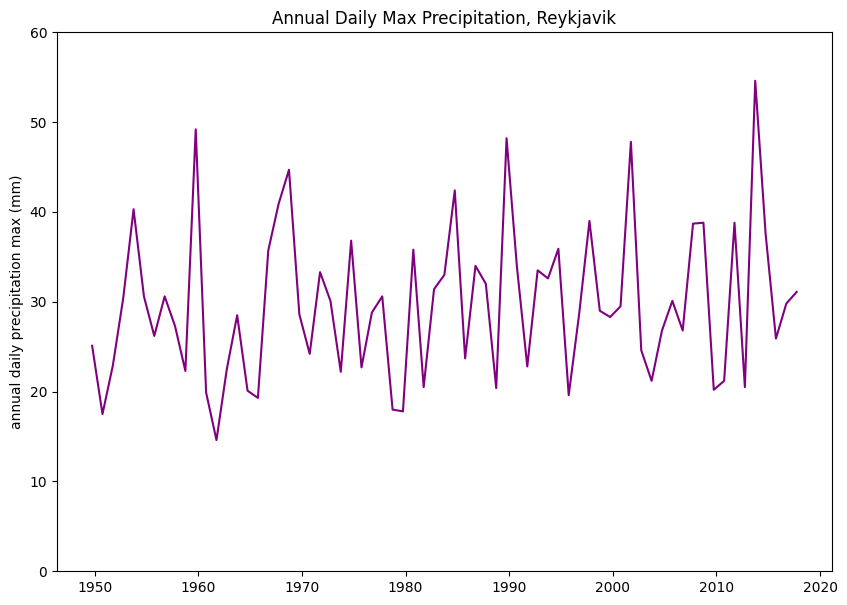

In [26]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(max_annual['PRCP'], color='purple')
ax.set(title="Annual Daily Max Precipitation, Reykjavik")
ax.set(ylabel="annual daily precipitation max (mm)",
       ylim=[0, 60]);

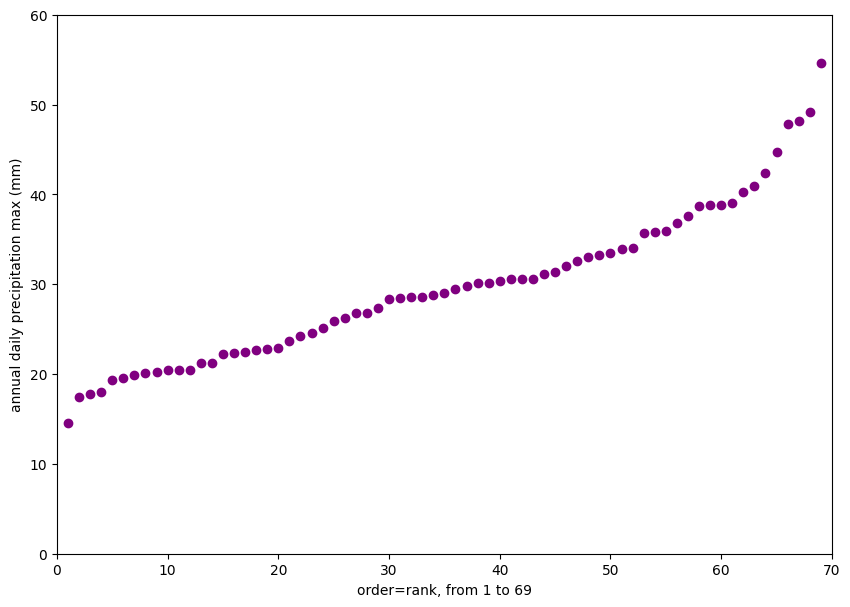

In [27]:
# sort yearly max from highest to lowest
max_annual = max_annual.sort_values(by=['PRCP'], ascending=True)
max_annual['rank'] = np.arange(1, len(max_annual) + 1)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(max_annual['rank'], max_annual['PRCP'], 'o', color='purple')
ax.set(ylabel="annual daily precipitation max (mm)",
       xlabel=f"order=rank, from 1 to {len(max_annual)}",
       ylim=[0, 60],
       xlim=[0, 70]);

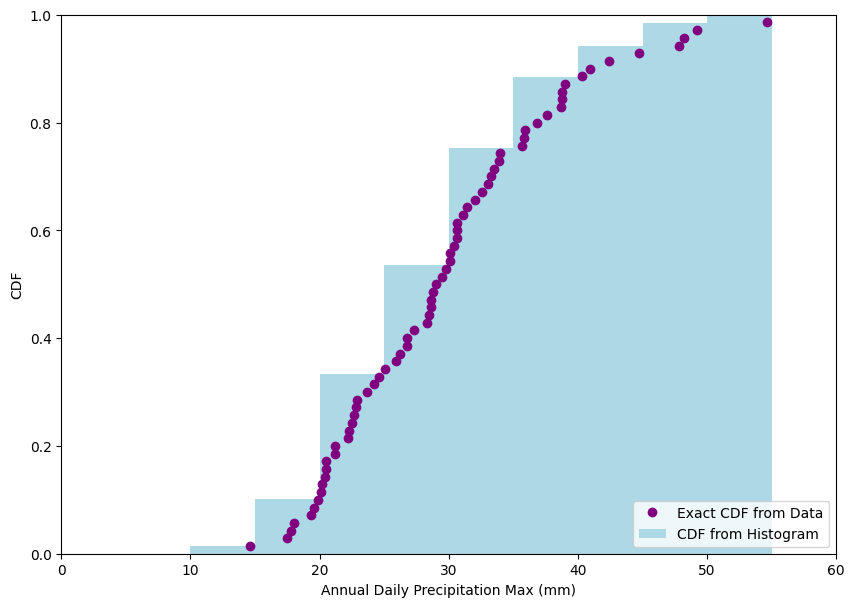

In [28]:
n = len(max_annual['rank'])
m = max_annual['rank']
cdf_fromdata = m / (n+1)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(max_annual['PRCP'], cdf_fromdata, 'o', label="Exact CDF from Data", color='purple')
ax.hist(h, bins=bins, cumulative=1, density=True, histtype="bar", color="lightblue", label="CDF from Histogram")
ax.legend(loc="lower right")
ax.set(xlabel="Annual Daily Precipitation Max (mm)",
       ylabel=f"CDF",
       xlim=[0, 60],
       ylim=[0, 1]);

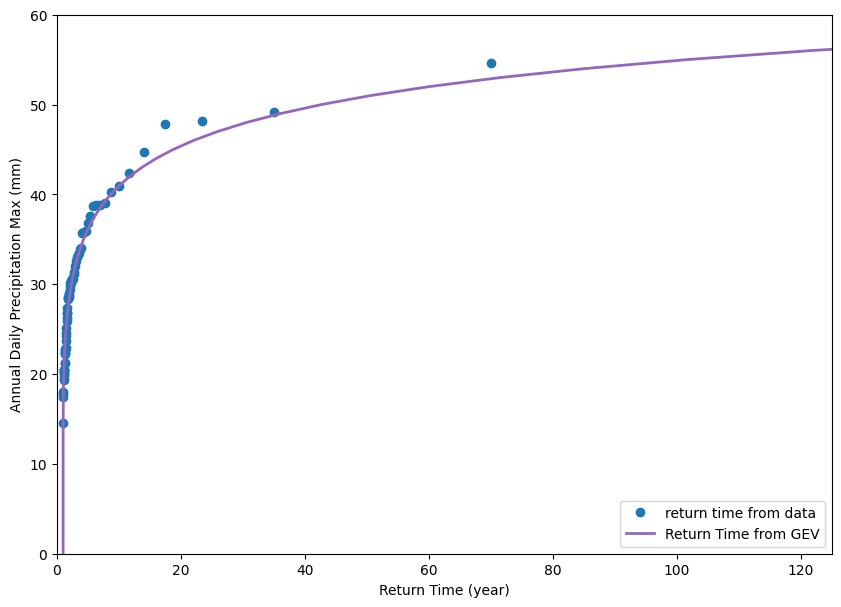

In [29]:
fig, ax = plt.subplots(figsize=(10,7))

T = 1 / (1-cdf_fromdata)
ax.plot(T, max_annual['PRCP'], 'o', label="return time from data")

ax.plot(1/(1-cdf(rain)), rain, color='tab:purple', lw=2, label="Return Time from GEV")
ax.legend(loc="lower right", frameon=True)
ax.set(xlabel="Return Time (year)",
       ylabel=f"Annual Daily Precipitation Max (mm)",
       xlim=[0, 125],
       ylim=[0, 60]);

### Penman

I wasn't able to get the Rn for the PET, therefore, I used the pyet ability to infer the solar radiation given the station latitude and the number of daylight hours.

#### Classes and Functions

In [30]:
class Penman():
    def __init__(self, year):
        self.year = year
        self.df_for_penman = download_hourly_data(self.year)

    def penman(self):
        self.df_for_penman = self.df_for_penman.copy()
        self.df_for_penman = self.df_for_penman.resample('D').mean()

        elevation = 0  # meters
        lat = 64.147  # degrees
        lat = pyet.utils.deg_to_rad(lat)
        self.df_for_penman['daylight_duration'] = pyet.meteo_utils.daylight_hours(self.df_for_penman["temperature_2m"].index, lat)

        self.penm3 = pyet.combination.penman(
                                tmean=self.df_for_penman["temperature_2m"],
                                wind=self.df_for_penman["wind_speed_10m"],
                                elevation=elevation,
                                rh=self.df_for_penman["relative_humidity_2m"],
                                lat=lat,
                                n=self.df_for_penman['daylight_duration']
                                )

        fig, ax = plt.subplots(1)
        ax.plot(self.penm3, label="Evapotranspiration")
        ax.set_xlabel("Date")

        ax.legend()
        plt.gcf().autofmt_xdate()  # makes slated dates
        ax.set_ylabel("ET (mm/day)")
        plt.savefig(f"output/penman_output/penman_{self.year}.png")



    def penman_daylight(self):
        # create 2 subplots of penm3 and daylight_duration
        fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
        ax[0].plot(self.penm3, label="ET (mm/day)", color='red')
        ax[0].legend()
        ax[0].set_ylabel("ET (mm/day)")
        ax[0].set_xlabel("Date")
        ax[1].plot(self.df_for_penman['daylight_duration'], label="Daylight Duration (hours)", color='orange')
        ax[1].legend()
        ax[1].set_ylabel("Daylight Duration (hours)")
        ax[1].set_xlabel("Date")
        plt.gcf().autofmt_xdate()  # makes slated
        plt.savefig(f"output/penman_output/penman_daylight_{self.year}.png")


    def penman_fao(self):
        fig, ax = plt.subplots(1)
        ax.plot(self.df_for_penman["et0_fao_evapotranspiration"], label="FAO ET0", color='grey')
        ax.plot(self.penm3, label="Penman-Monteith", color='blue')
        ax.legend()
        plt.gcf().autofmt_xdate()  # makes slated dates
        ax.set_ylabel("ET (mm/day)")
        ax.set_xlabel("Date")
        plt.savefig(f"output/penman_output/penman_fao_{self.year}.png")
        plt.show()
        


    def more_data(self):
        es = pyet.meteo_utils.calc_es(tmean=self.df_for_penman["temperature_2m"])
        ea = pyet.meteo_utils.calc_ea(tmean=self.df_for_penman["temperature_2m"],
                                    rh=self.df_for_penman["relative_humidity_2m"])
        vpd = es - ea
        
        sns.set_theme(style="ticks", font_scale=1.0)
        fig, ax = plt.subplots(6,1, figsize=(10,15), sharex=True)
        ax[0].plot(self.penm3); ax[0].set_ylabel("potential ET (mm/day)")
        ax[1].plot(self.df_for_penman['temperature_2m']); ax[1].set_ylabel("temperature (°C)")
        ax[2].plot(self.df_for_penman['relative_humidity_2m']); ax[2].set_ylabel("relative humidity (%)")
        ax[3].plot(self.df_for_penman['wind_speed_10m']); ax[3].set_ylabel("wind speed (m/s)")
        ax[4].plot(self.df_for_penman['daylight_duration']); ax[4].set_ylabel("Daylight Duration (hours)")
        ax[5].plot(vpd); ax[5].set_ylabel("VPD (kPa)"); ax[5].set_xlabel("Date")
        plt.savefig(f"output/penman_output/penman_more_data_{self.year}.png")





#### Instances

Each year has it's plots and, overall, it looks the same.  
We'll discuss the results after all instances.

##### 2005

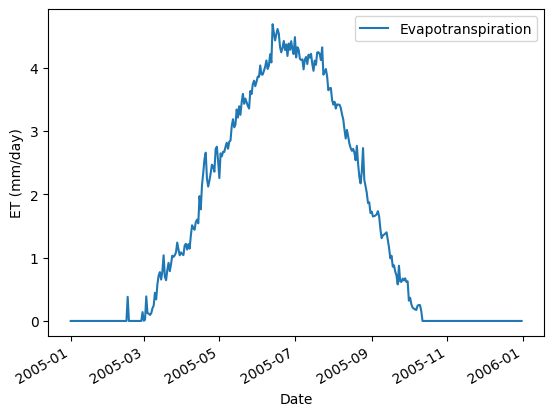

In [31]:
year1 = Penman(2005)
year1.penman()

The ET in the beginning and end of the year is 0, we need to understand why.

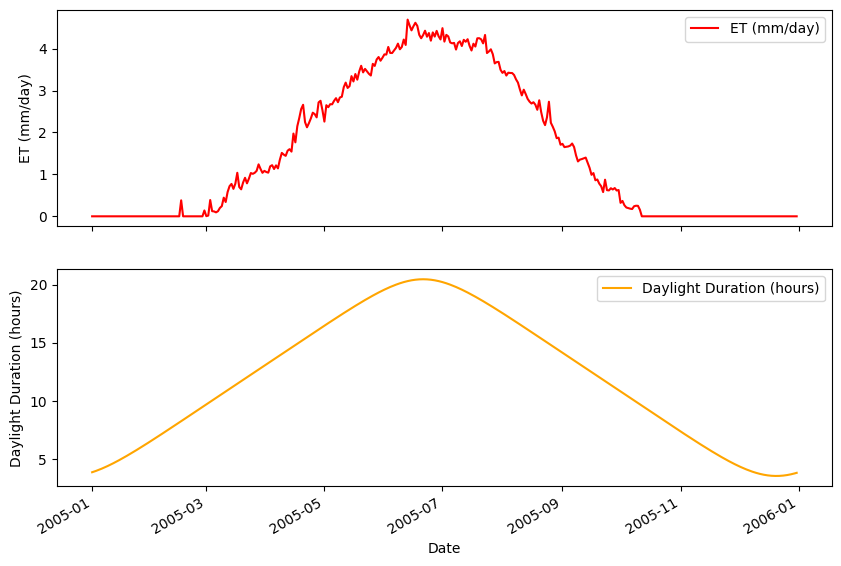

In [32]:
year1.penman_daylight()

The daylight hours are very short in the winter in Iceland, thats probably the reason the calculated ET is so low.
The open-meteo API is also able to extract the FAO ET0, let's compare the PET we calculated using pyet to the FAO ET0.

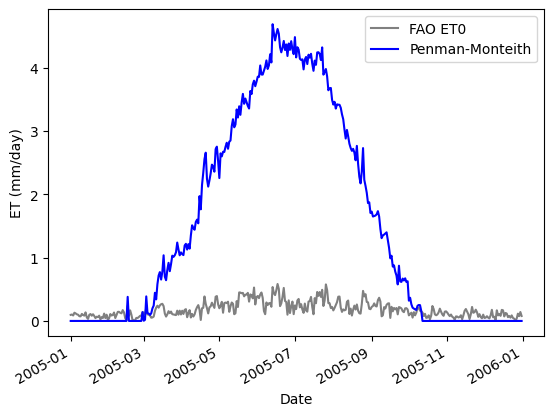

In [33]:
year1.penman_fao()

Very different results, probably duo to the fact that this is FAO ET0 and not the actual ET.  
We can see that in the winter, the ET is low but is no zero.

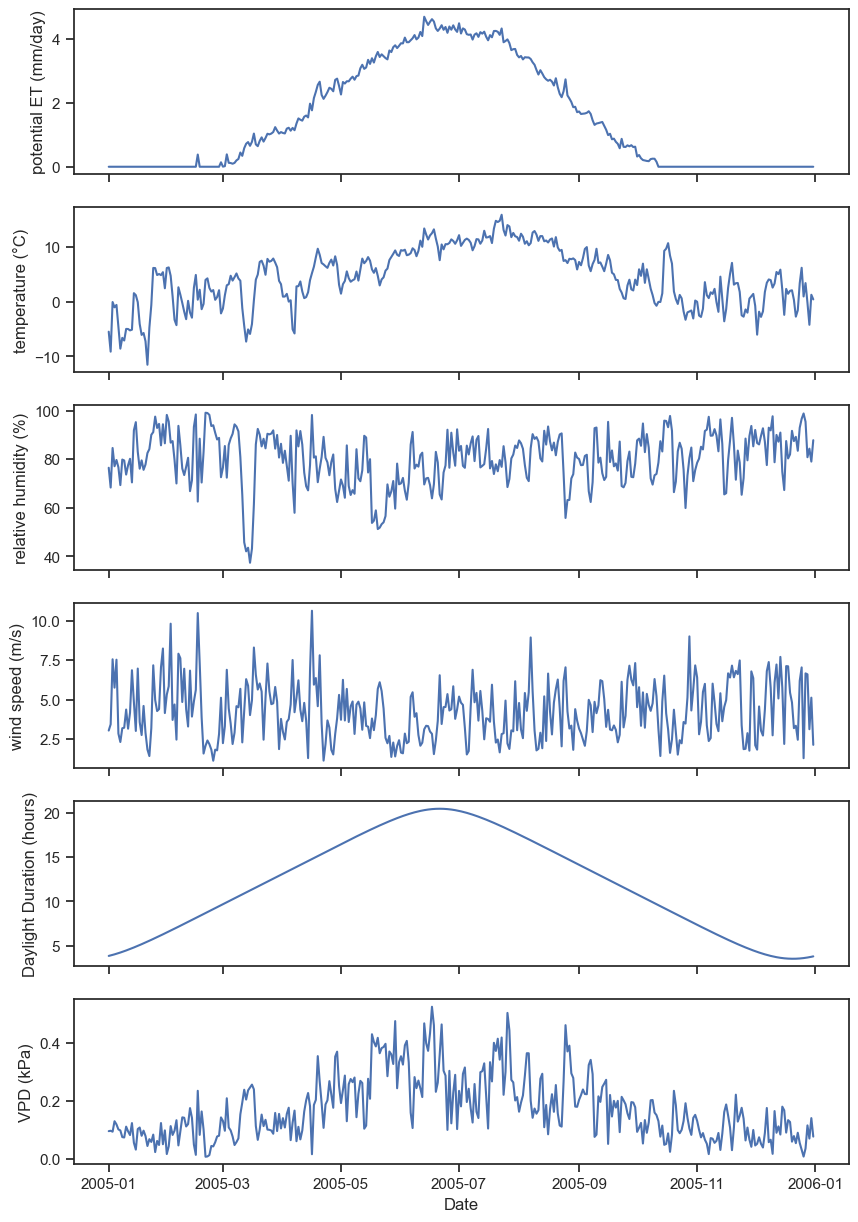

In [34]:
year1.more_data()

##### 2008

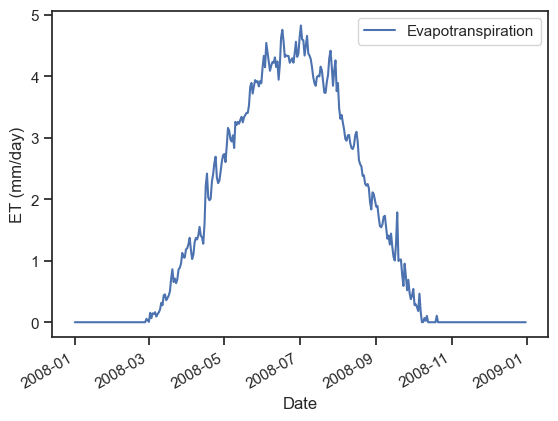

In [35]:
year2 = Penman(2008)
year2.penman()

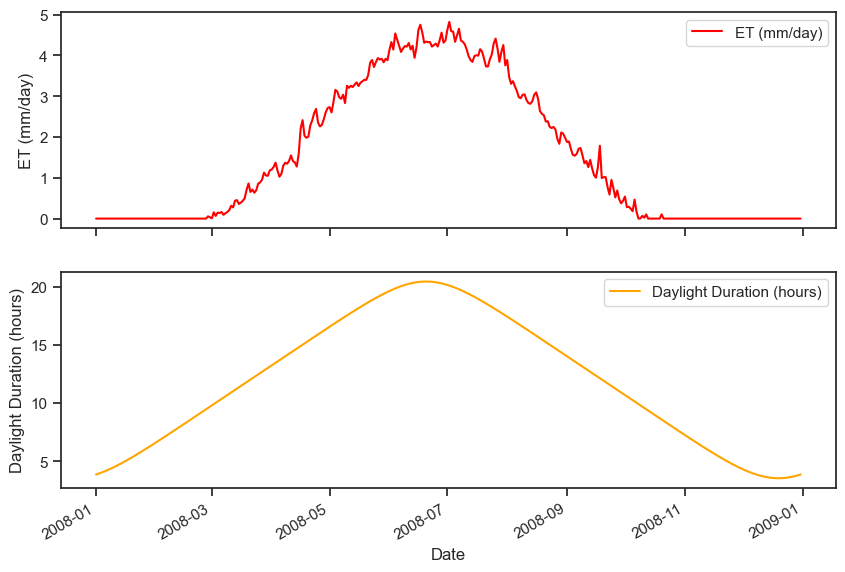

In [36]:
year2.penman_daylight()

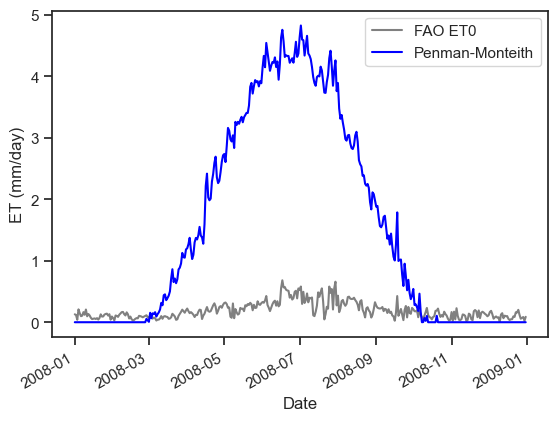

In [37]:
year2.penman_fao()

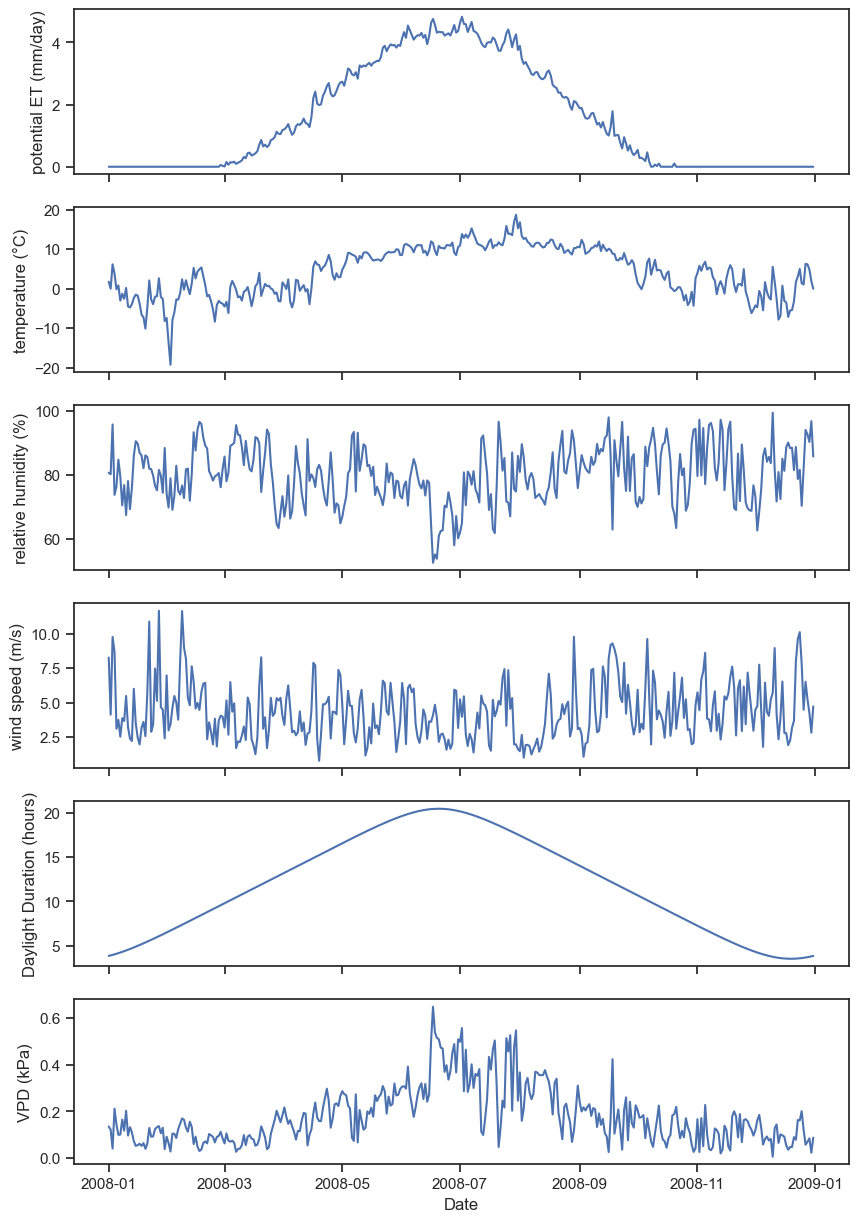

In [38]:
year2.more_data()

##### 2010

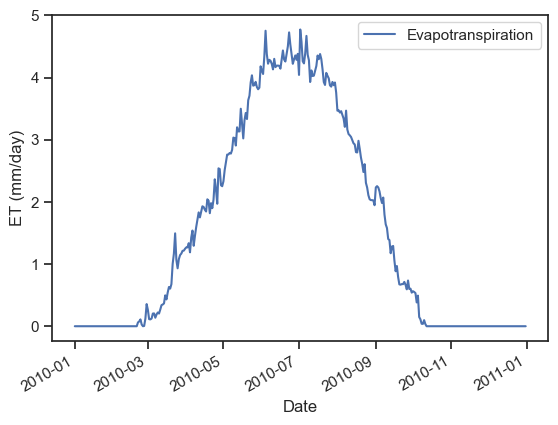

In [39]:
year3 = Penman(2010)
year3.penman()

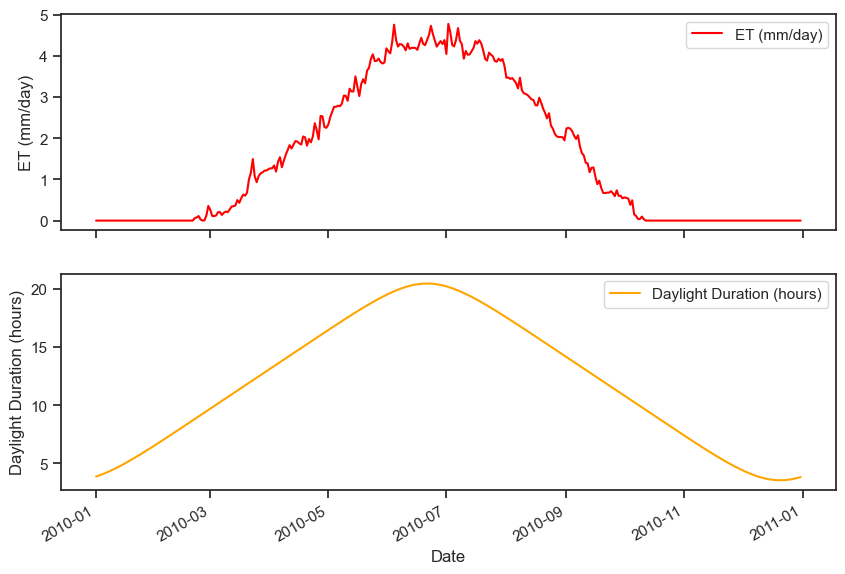

In [40]:
year3.penman_daylight()

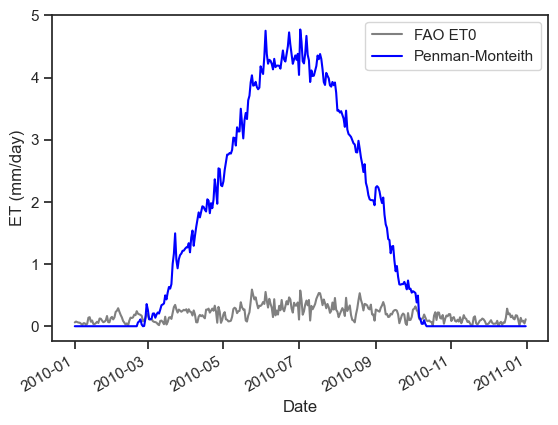

In [41]:
year3.penman_fao()

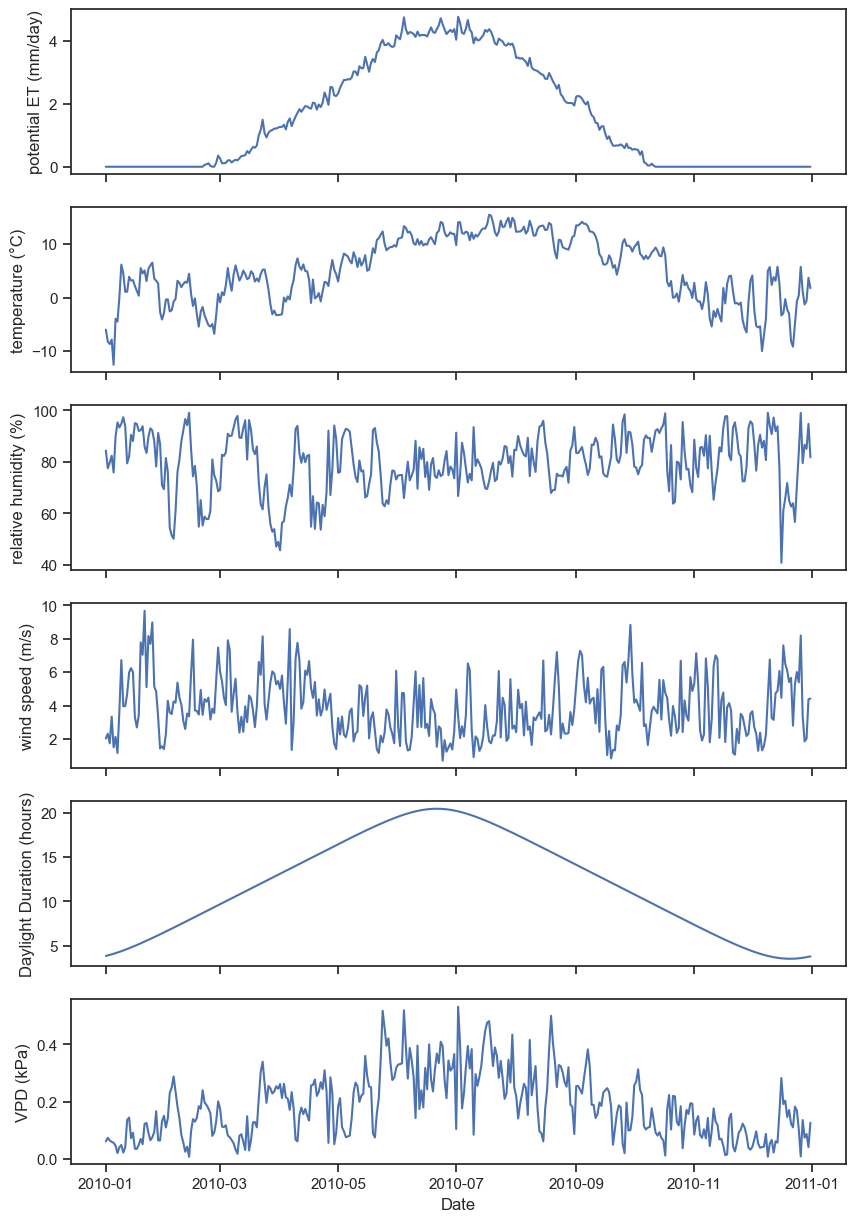

In [42]:
year3.more_data()

##### 2012

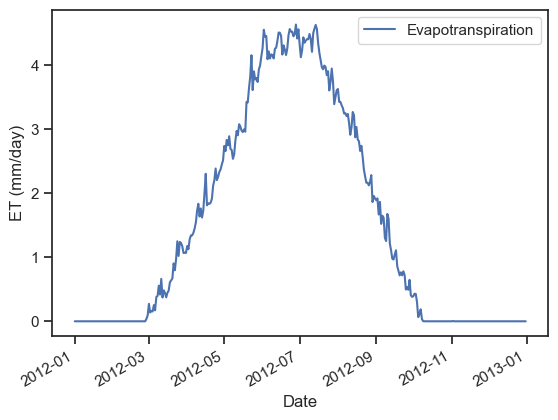

In [43]:
year4 = Penman(2012)
year4.penman()

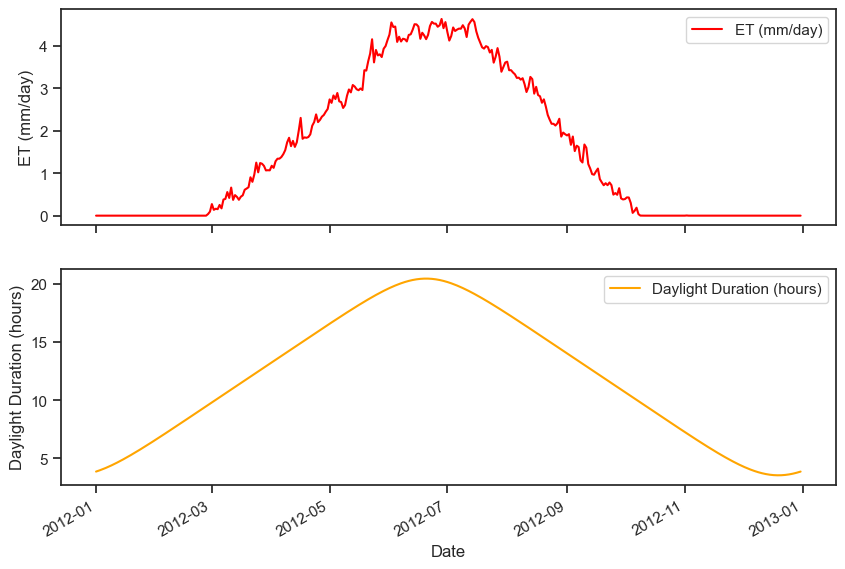

In [44]:
year4.penman_daylight()

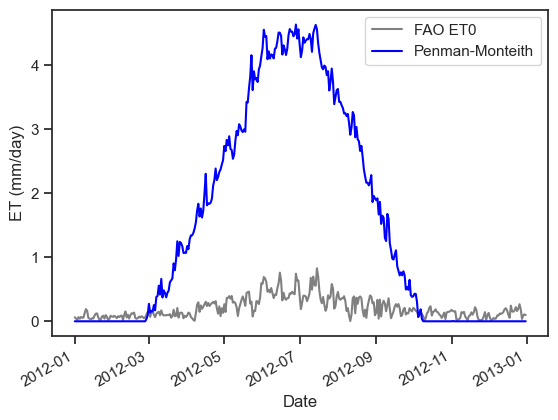

In [45]:
year4.penman_fao()

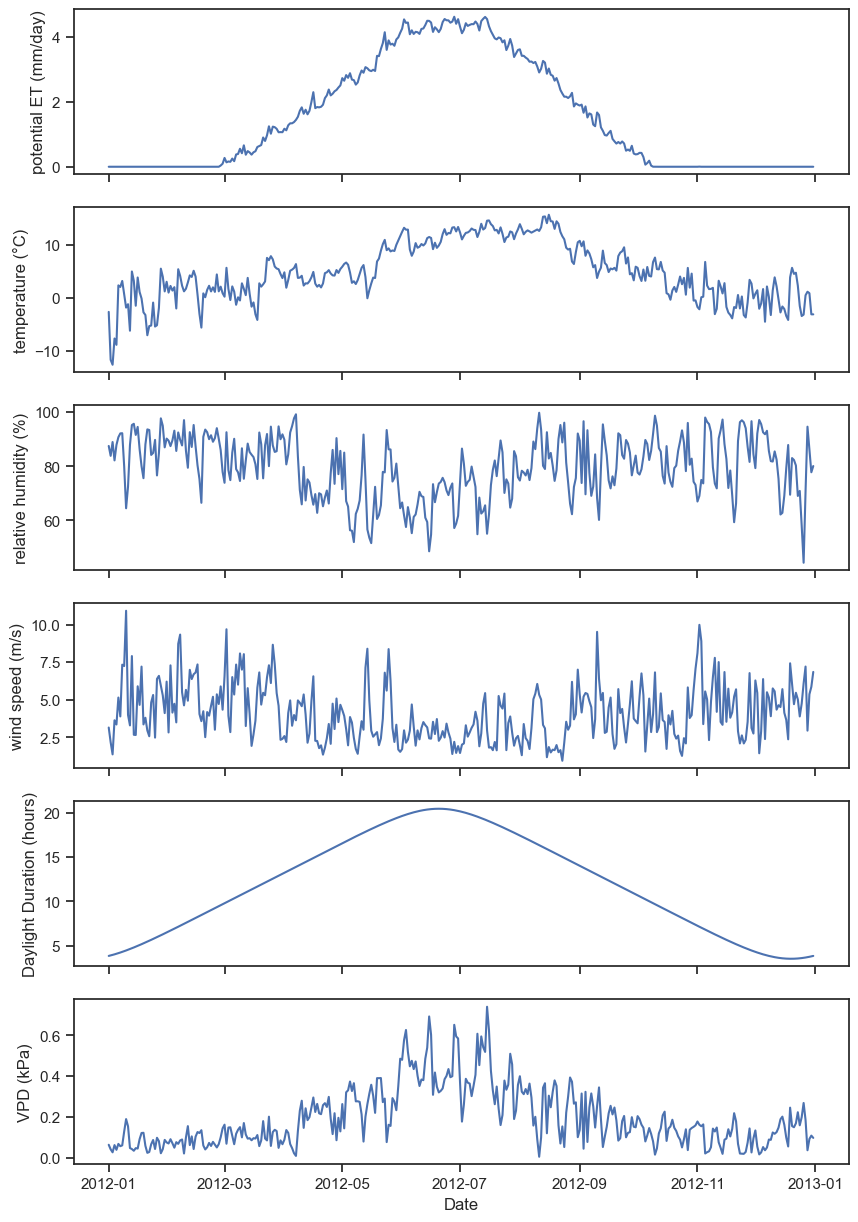

In [46]:
year4.more_data()

##### 2014

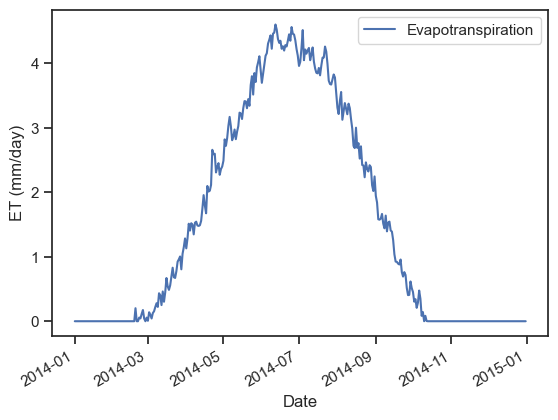

In [47]:
year5 = Penman(2014)
year5.penman()

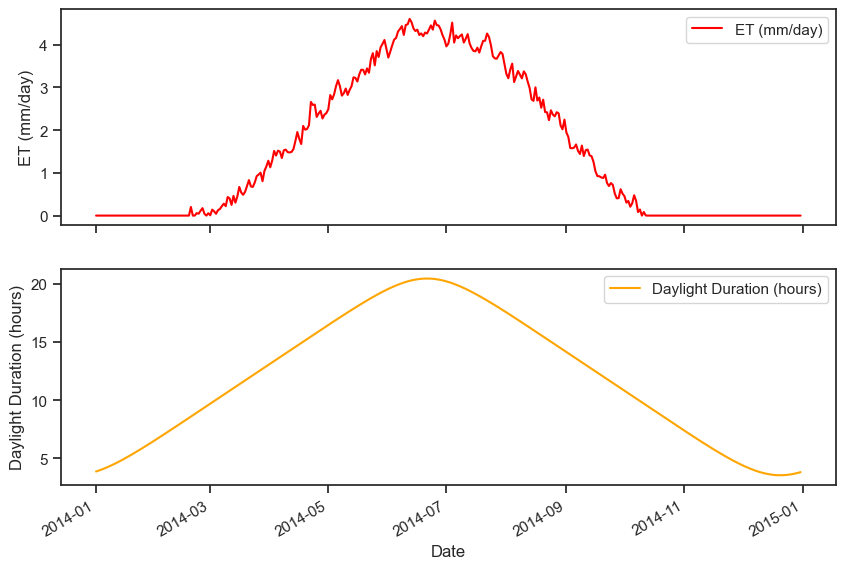

In [48]:
year5.penman_daylight()

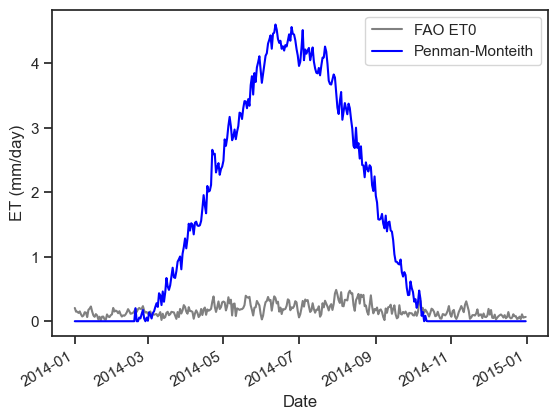

In [49]:
year5.penman_fao()

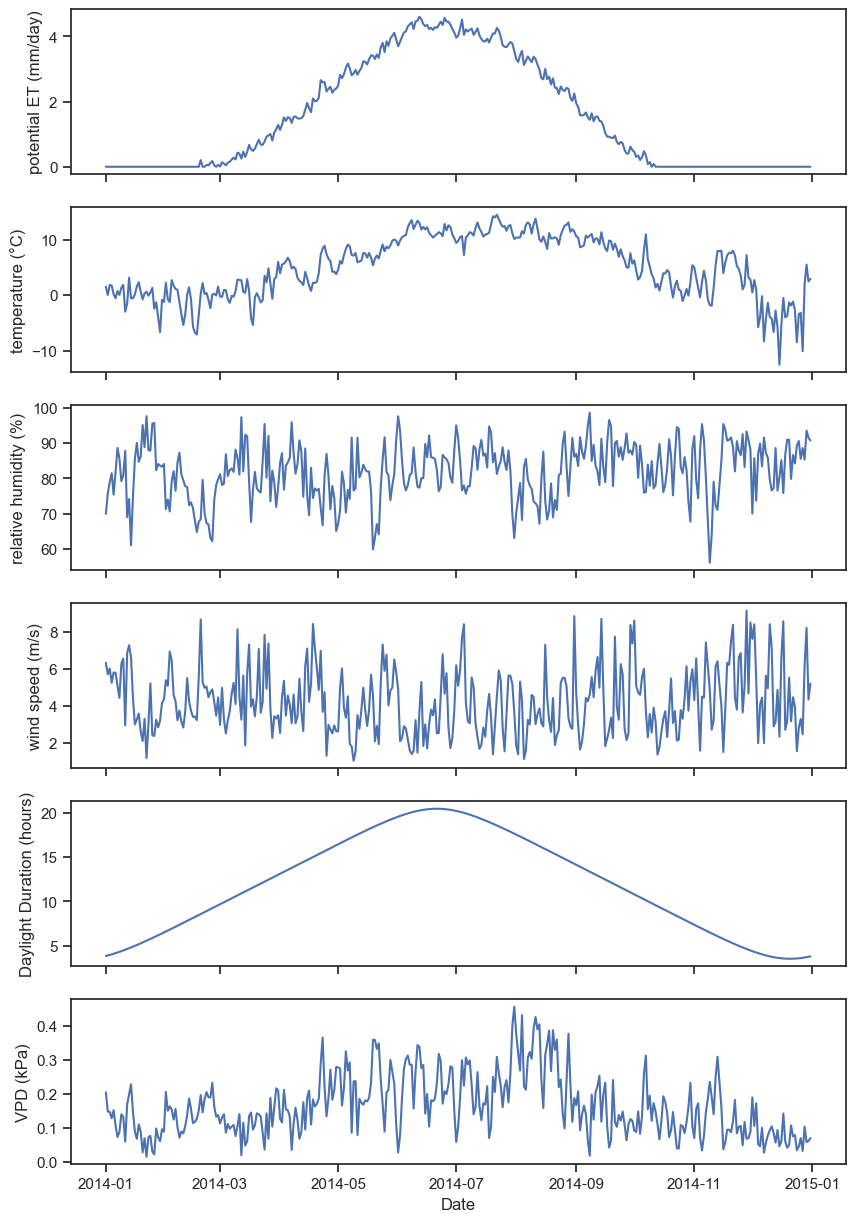

In [50]:
year5.more_data()

##### The calculated ET ranges between 0 and 5 mm/day, no significant differences appeared between the years.
##### A more in-depth explanation is in the attached PDF.

----- from here to pdf
##### The difference between the calculated ET (using pyet module and the data from open-meteo API) and the FAO ET0 from the same source,
##### can derive from the fact that this is the ET0, and therefore needs to be multiplied by some factor.
##### Another reason that can cause this difference, is that many assumptions were taken when calculating, primarily the Rn.


# 2010 Eruption

## Precipitation

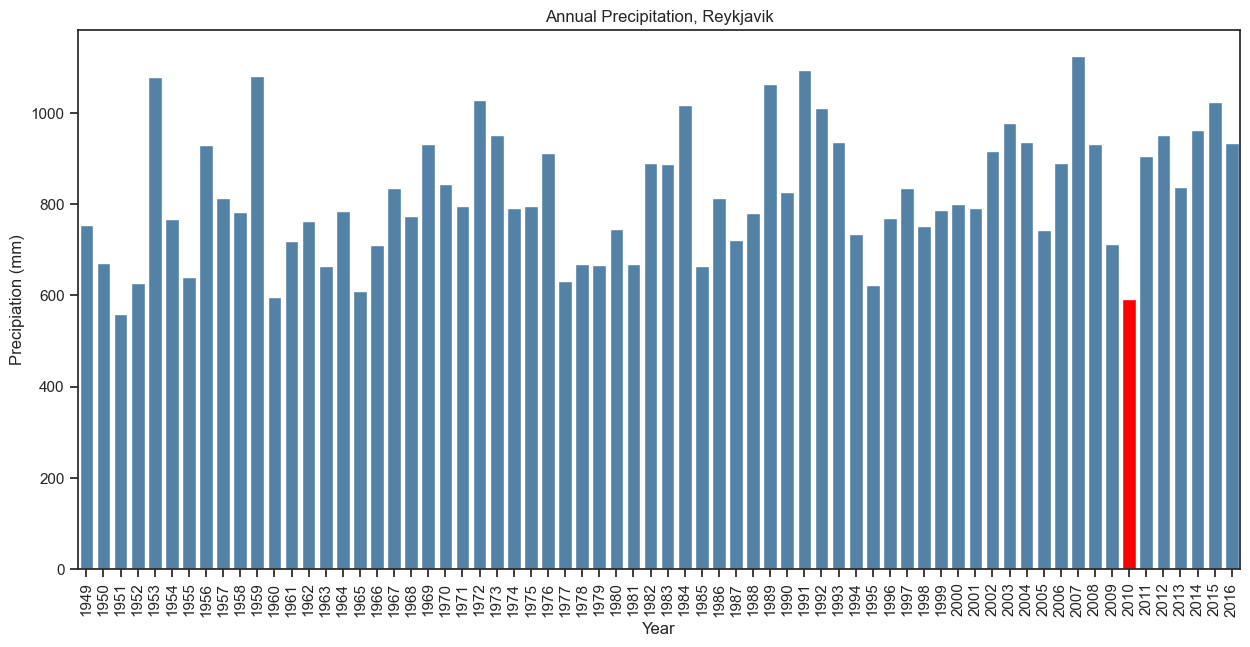

In [51]:
# let's get the annual average precipitation
df_annual_avg = (df_daily['PRCP'].resample('YE').sum())

fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(x=df_annual_avg.index.year, y=df_annual_avg, color='steelblue')
ax.set(xlabel="Year",
       ylabel="Precipiation (mm)",
       title="Annual Precipitation, Reykjavik",);
plt.xticks(rotation=90);

# lets change the color of 2010 to red
ax.patches[61].set_facecolor('red')
plt.savefig("output/annual_precipitation.png")
plt.show()




The eruption of Eyjafjallajökull volcano in 2010 lasted 39 days, 14 April–23 May.  
The eruption had two explosive phases separated by a phase with lava formation and reduced explosive activity. 

Petersen, G. N., H. Bjornsson, and P. Arason (2012), The impact of the atmosphere on the Eyjafjallajökull 2010eruption plume, J. Geophys. Res., 117, D00U07, doi:10.1029/2011JD016762

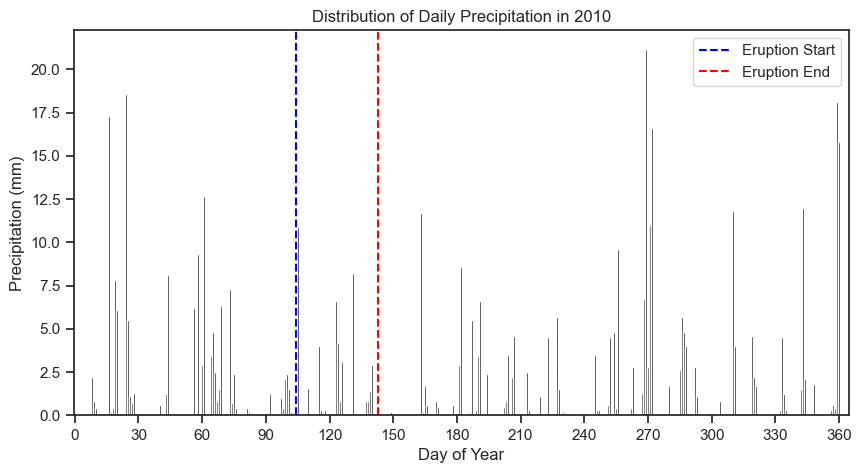

In [52]:
# lets zoom into 2010
df_2010 = df_daily[df_daily.index.year == 2010]

eruption_day = 104 # doy of the eruption
end_date = 143 # doy of the end of the eruption


plt.figure(figsize=(10, 5))
sns.barplot(x=df_2010.index, y=df_2010['PRCP'], color='black')
plt.title('Distribution of Daily Precipitation in 2010')
plt.xlabel('Day of Year')
plt.ylabel('Precipitation (mm)')

# lets make the x axis labels doy (day of year)
plt.xticks(np.arange(0, 366, 30), labels=np.arange(0, 366, 30));

# lets add a vertical line to indicate the eruption
plt.axvline(x=eruption_day, color='blue', linestyle='--', label='Eruption Start')
plt.axvline(x=end_date, color='red', linestyle='--', label='Eruption End')
plt.legend()
plt.show()



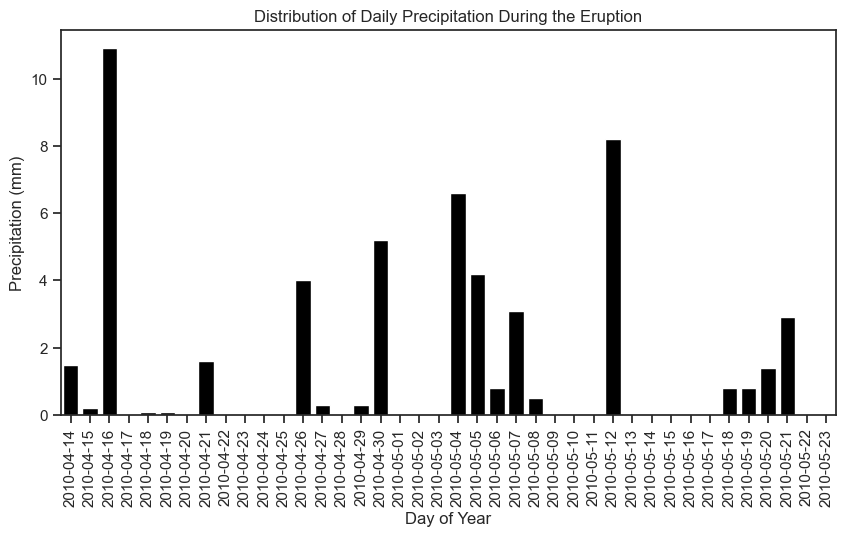

In [53]:
# lets zoom into the eruption
df_eruption = df_2010[(df_2010.index.dayofyear >= eruption_day) & (df_2010.index.dayofyear <= end_date)]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=df_eruption.index, y=df_eruption['PRCP'], color='black')
plt.title('Distribution of Daily Precipitation During the Eruption')
plt.xlabel('Day of Year')
plt.ylabel('Precipitation (mm)')

# lets make the x axis labels doy (day of year)
plt.xticks(rotation=90);
plt.show()

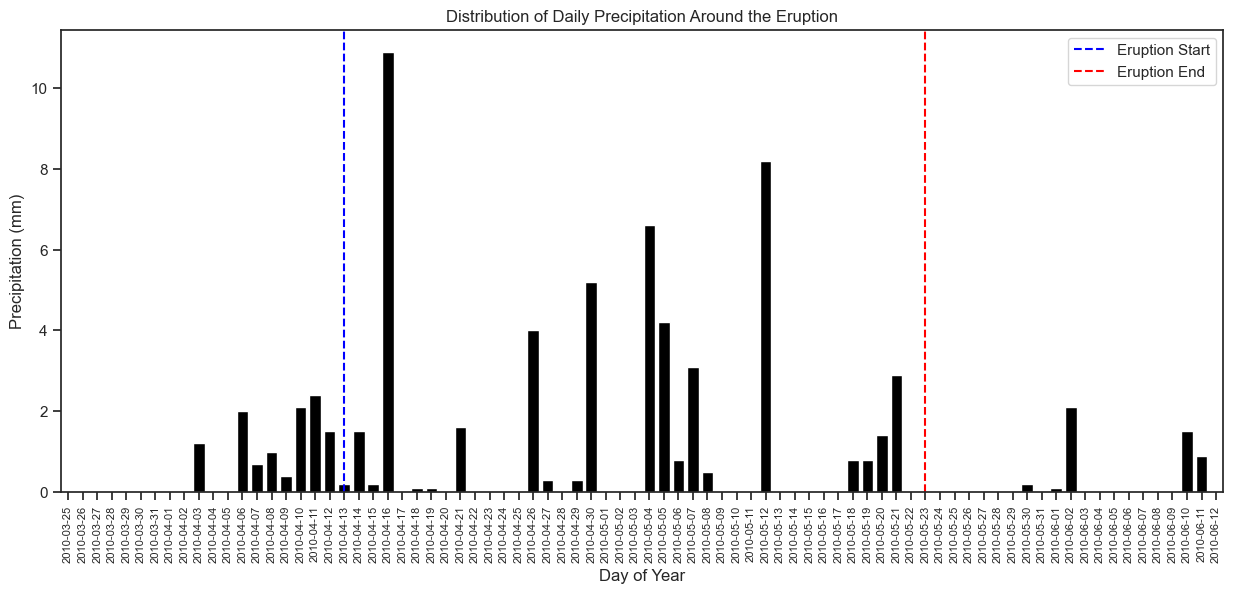

In [54]:
# we have a 39 days window around the eruption, lets see the distribution of precipitation in that window
df_eruption_window_extended = df_2010[(df_2010.index.dayofyear >= eruption_day - 20) & (df_2010.index.dayofyear <= end_date + 20)]
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=df_eruption_window_extended.index, y=df_eruption_window_extended['PRCP'], color='black')
plt.title('Distribution of Daily Precipitation Around the Eruption')
plt.xlabel('Day of Year')
plt.ylabel('Precipitation (mm)')
# lets add a vertical line to indicate the eruption
plt.axvline(x='2010-04-13', color='blue', linestyle='--', label='Eruption Start')
plt.axvline(x='2010-05-23', color='red', linestyle='--', label='Eruption End')
plt.legend()

# we'll make the xlabels font smaller
plt.xticks(rotation=90, fontsize=8);
plt.savefig("output/daily_precipitation_eruption_window.png")
plt.show()

At first look, it seems that the area within the eruption episode has more precipitation

The average precipitation during the eruption was 1.34 mm
The standard deviation of the precipitation during the eruption was 2.51 mm
The average precipitation during the same window in the previous years was 1.59 mm
The standard deviation of the precipitation during the same window in the previous years was 2.99 mm


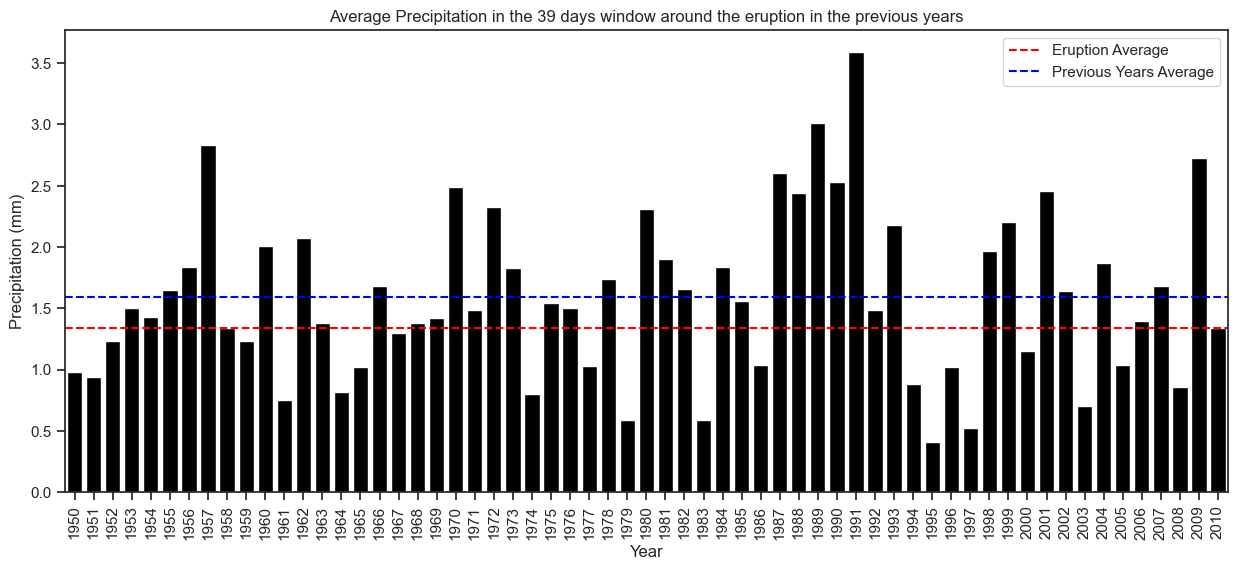

In [55]:
# lets calculate the average precipitation in the 39 days window
df_eruption_window = df_2010[(df_2010.index.dayofyear >= eruption_day) & (df_2010.index.dayofyear <= end_date)]
avg_prcp = df_eruption_window['PRCP'].mean().round(2)
print(f'The average precipitation during the eruption was {avg_prcp} mm')

# and the standard deviation
std_prcp = df_eruption_window['PRCP'].std().round(2)
print(f'The standard deviation of the precipitation during the eruption was {std_prcp} mm')

# and now we'll see how unusual this event was, let's look at the same dates in the previous years
df_eruption_window_prev50 = df_daily[(df_daily.index.year >= 1950) & (df_daily.index.year <= 2009) & 
                                 (df_daily.index.dayofyear >= eruption_day) & (df_daily.index.dayofyear <= end_date)]
avg_prcp_10 = df_eruption_window_prev50['PRCP'].mean().round(2)
std_prcp_10 = df_eruption_window_prev50['PRCP'].std().round(2)
print(f'The average precipitation during the same window in the previous years was {avg_prcp_10} mm')
print(f'The standard deviation of the precipitation during the same window in the previous years was {std_prcp_10} mm')

df_eruption_window_prev50 = df_daily[(df_daily.index.year >= 1950) & (df_daily.index.year <= 2010) & 
                                 (df_daily.index.dayofyear >= eruption_day) & (df_daily.index.dayofyear <= end_date)]
yearly_window = df_eruption_window_prev50.groupby(df_eruption_window_prev50.index.year)['PRCP'].mean().round(2)
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=yearly_window.index, y=yearly_window, color='black')
plt.title('Average Precipitation in the 39 days window around the eruption in the previous years')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
# let's add the average precipitation during the eruption
plt.axhline(y=avg_prcp, color='red', linestyle='--', label='Eruption Average')
plt.axhline(y=avg_prcp_10, color='blue', linestyle='--', label='Previous Years Average')
plt.legend()
plt.xticks(rotation=90);
plt.savefig("output/eruption_window_comparison_to_prev_years.png")
plt.show()



The average precipitation during the eruption episode is 1.34 mm per day, with std of 2.51 mm.  
The average precipitation during the 10 years prior the eruption episode is 1.59 mm per day, with std of 2.99 mm.

Although the difference is small and to the opposite of our first hypothesis, (the precipitation is actually lower),   
let's see if the difference is significant:

In [56]:
# let's see if the mean is significantly different using a t test
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(df_eruption_window['PRCP'], df_eruption_window_prev50['PRCP'])
print(f'The p-value of the t-test is {p_val}')

# and now with mannwhitneyu
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(df_eruption_window['PRCP'], df_eruption_window_prev50['PRCP'])
print(f'The p-value of the Mann-Whitney U test is {p}')


The p-value of the t-test is 0.5989181388521632
The p-value of the Mann-Whitney U test is 0.5182142965920389


The difference is not significant, we can interpret nothing from the analysis so far.

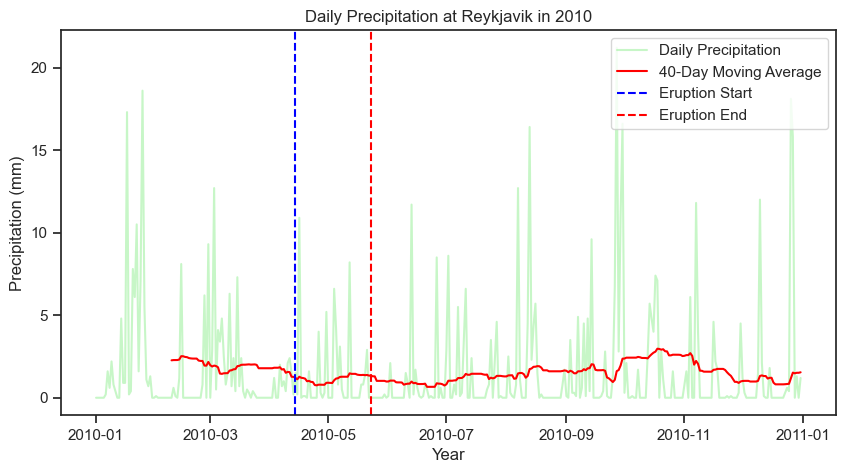

In [57]:
# let's plot the daily precipitation data of df_2010 and calculate a moving average
fig, ax = plt.subplots(figsize=(10, 5))
window = 40
ax.plot(df_2010['PRCP'], label='Daily Precipitation', color='lightgreen', alpha=0.5)
ax.plot(df_2010['PRCP'].rolling(window=window).mean(), label=f'{window}-Day Moving Average', color='red')

plt.title('Daily Precipitation at Reykjavik in 2010')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.axvline(x=df_2010.index[eruption_day-1], color='blue', linestyle='--', label='Eruption Start')
plt.axvline(x=df_2010.index[end_date-1], color='red', linestyle='--', label='Eruption End')
plt.legend(loc='upper right')
plt.savefig("output/daily_precipitation_2010_moving_average.png")
plt.show()

Looking at this moving average, I don't think we can learn much, even when playing with the window size, it doesn't tell us anything.  
Another thing we can see, is that no 'after-eruption' special behavior is apparent.  

## Temperature

We analyzed the precipitation, now let's look at the temperature changes.  
The TMIN and TMAX are taken fom the NOAA daily data, while the hourly temperature is taken from the hourly data retrieved from the Open-Meteo API.

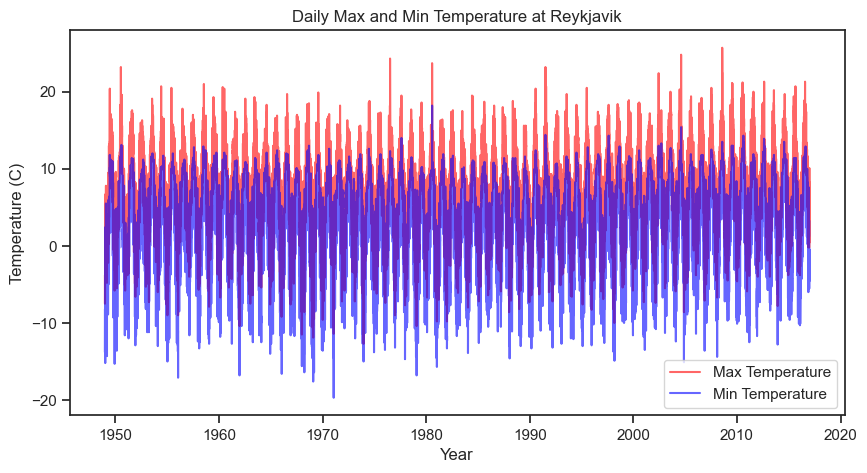

In [58]:
# first, let's plot the daily max and min temperature data
# let's try to plot them together

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_daily['TMAX'], label='Max Temperature', color='red', alpha=0.6)
ax.plot(df_daily['TMIN'], label='Min Temperature', color='blue', alpha=0.6)


plt.title('Daily Max and Min Temperature at Reykjavik')
plt.xlabel('Year')
plt.ylabel('Temperature (C)')
plt.legend()
plt.savefig("output/tmin_max_temps_allyears.png")
plt.show()


In [59]:
print(f'Daily max temp maximum: {df_daily['TMAX'].max()}')
print(f'Daily min temp minimum: {df_daily['TMIN'].min()}')


Daily max temp maximum: 25.7
Daily min temp minimum: -19.7


In [60]:
# let's calculate the variance of the daily max temperature
variance_max = df_daily['TMAX'].var()
print(f'The variance of the daily max temperature is {variance_max:.2f}')
variance_min = df_daily['TMIN'].var()
print(f'The variance of the daily min temperature is {variance_min:.2f}')


The variance of the daily max temperature is 27.60
The variance of the daily min temperature is 29.36


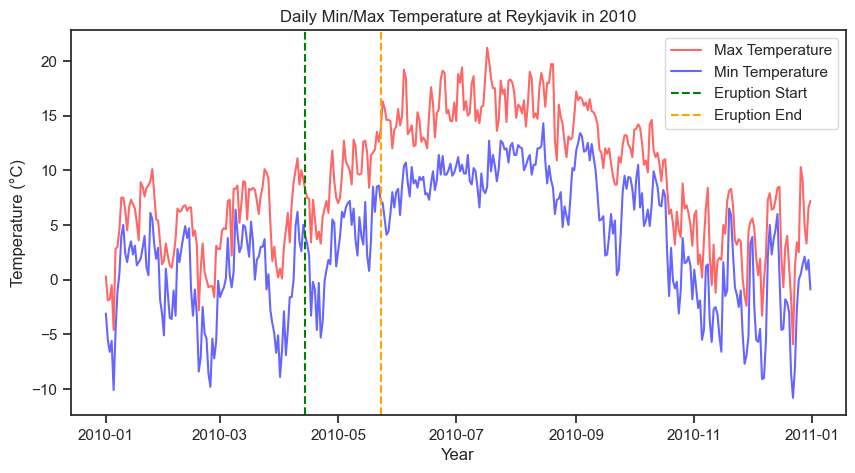

In [61]:
# now let's look only at the eruption's year
df_eruption = df_daily[df_daily.index.year == 2010]
plt.figure(figsize=(10, 5))
plt.plot(df_eruption['TMAX'], label='Max Temperature', color='red', alpha=0.6)
plt.plot(df_eruption['TMIN'], label='Min Temperature', color='blue', alpha=0.6)
plt.title('Daily Min/Max Temperature at Reykjavik in 2010')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')

plt.axvline(x=df_eruption.index[eruption_day-1], color='green', linestyle='--', label='Eruption Start')
plt.axvline(x=df_eruption.index[end_date-1], color='orange', linestyle='--', label='Eruption End')

plt.legend()
plt.savefig("output/tmin_max_temps_2010.png")
plt.show()


From the graph we can see that the temperatures increased towards the summer, and we can't really see anything special around the eruption.  
We will have to look in a different way.

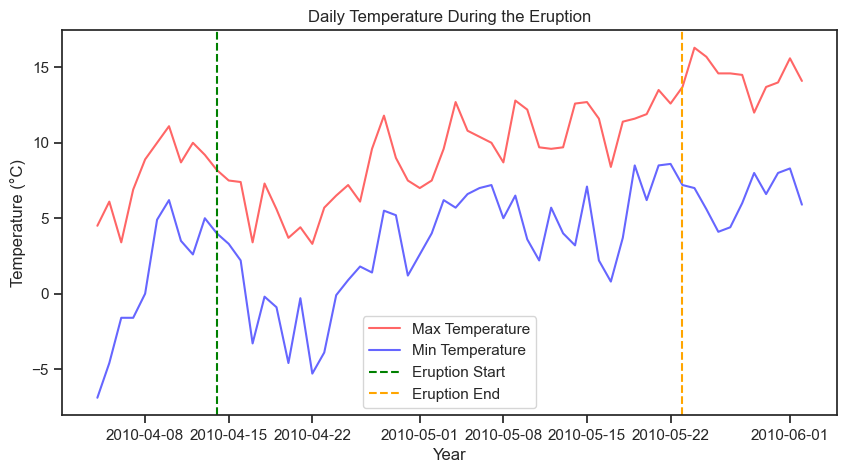

In [62]:
# let's only look at the eruption window
df_eruption_window = df_eruption[(df_eruption.index.dayofyear >= eruption_day - 10) & (df_eruption.index.dayofyear <= end_date + 10)]
plt.figure(figsize=(10, 5))
plt.plot(df_eruption_window['TMAX'], label='Max Temperature', color='red', alpha=0.6)
plt.plot(df_eruption_window['TMIN'], label='Min Temperature', color='blue', alpha=0.6)
plt.title('Daily Temperature During the Eruption')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.axvline(x=df_eruption.index[eruption_day-1], color='green', linestyle='--', label='Eruption Start')
plt.axvline(x=df_eruption.index[end_date-1], color='orange', linestyle='--', label='Eruption End')
plt.legend()
plt.savefig("output/tmin_max_temps_erup_window.png")
plt.show()

We can see that right after the eruption, the temperatures dropped, and in the 22th of April, the temperatures started to rise again.  
This tells us nothing because it can be by chance, so we'll have to do some statistics to confirm or deny the hypotheses.

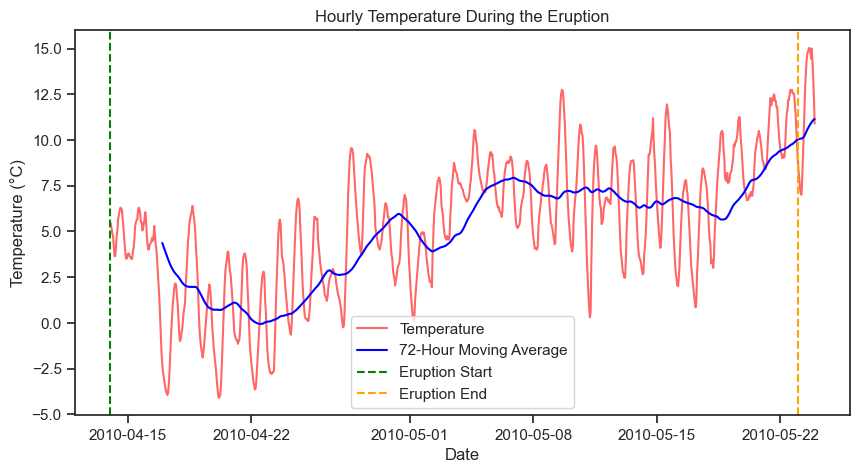

In [63]:
# let's plot the temps in the 39 days window but with the hourly data
hourly_df = download_hourly_data(2010)
df_eruption_window = hourly_df[(hourly_df.index.dayofyear >= eruption_day) & (hourly_df.index.dayofyear <= end_date)]
plt.figure(figsize=(10, 5))
plt.plot(df_eruption_window['temperature_2m'], label='Temperature', color='red', alpha=0.6)

# adding a moving average
window = 72
plt.plot(df_eruption_window['temperature_2m'].rolling(window=window).mean(), label=f'{window}-Hour Moving Average', color='blue')
plt.title('Hourly Temperature During the Eruption')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.axvline(x=df_eruption.index[eruption_day-1], color='green', linestyle='--', label='Eruption Start')
plt.axvline(x=df_eruption.index[end_date-1], color='orange', linestyle='--', label='Eruption End')
plt.legend(loc='lower center')
plt.savefig("output/tavg_erup_window.png")
plt.show()



While looking at the data, I thought that nothing special can be seen, but after a while, I thought maybe the ash cloud formed by the eruption might have a green house effect, and maybe the temperatures actually increased and not decreased as my initial hypothesis was.  
Next we'll compare the same time window in previous years to see if this behavior is different.

The average temperature during the eruption was 6.18 °C
The standard deviation of the temperature during the eruption was 3.15 °C
The average temperature during the same window in the previous years was 5.27 °C
The standard deviation of the temperature during the same window in the previous years was 3.04 °C


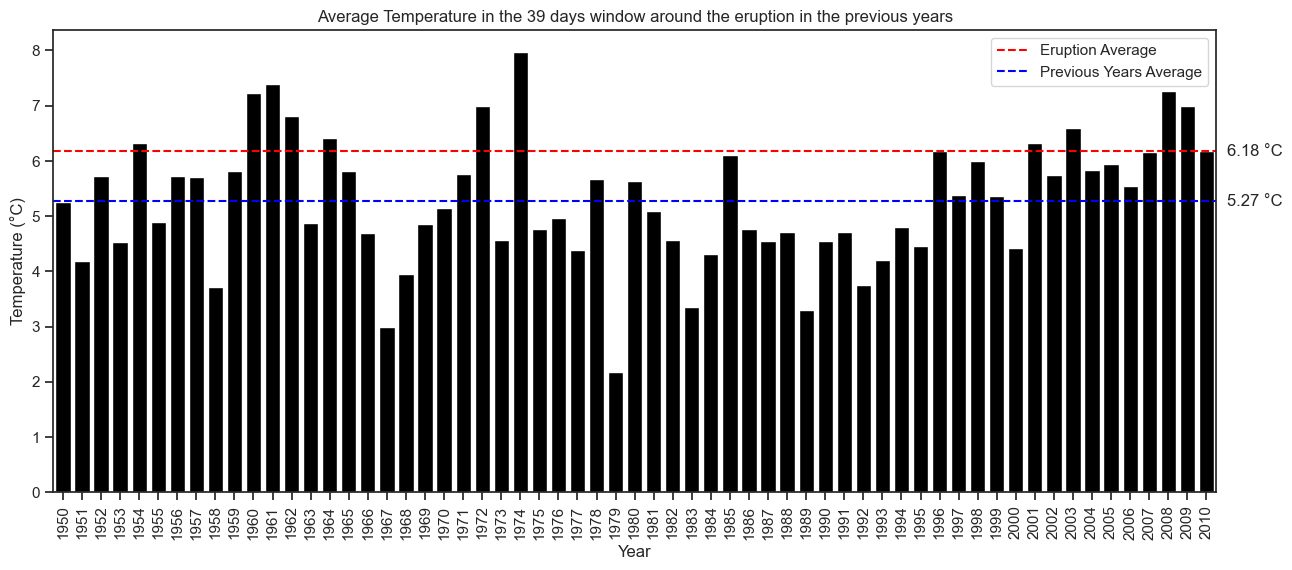

In [64]:
# we'll use the daily min and max to compute the daily average temperature, and then compare it to the same window in the previous years
df_daily['TAVG'] = (df_daily['TMAX'] + df_daily['TMIN']) / 2
df_eruption_window = df_daily[(df_daily.index.year == 2010) & (df_daily.index.dayofyear >= eruption_day) & (df_daily.index.dayofyear <= end_date)]
avg_temp = df_eruption_window['TAVG'].mean().round(2)
print(f'The average temperature during the eruption was {avg_temp} °C')
# and the standard deviation
std_temp = df_eruption_window['TAVG'].std().round(2)
print(f'The standard deviation of the temperature during the eruption was {std_temp} °C')

# and now we'll see how unusual this event was, let's look at the same dates in the previous years
df_eruption_window_prev50 = df_daily[(df_daily.index.year >= 1950) & (df_daily.index.year <= 2009) & 
                                 (df_daily.index.dayofyear >= eruption_day) & (df_daily.index.dayofyear <= end_date)]
avg_temp_50 = df_eruption_window_prev50['TAVG'].mean().round(2)
std_temp_50 = df_eruption_window_prev50['TAVG'].std().round(2)
print(f'The average temperature during the same window in the previous years was {avg_temp_50} °C')
print(f'The standard deviation of the temperature during the same window in the previous years was {std_temp_50} °C')

df_eruption_window_prev50 = df_daily[(df_daily.index.year >= 1950) & (df_daily.index.year <= 2010) &
                                    (df_daily.index.dayofyear >= eruption_day) & (df_daily.index.dayofyear <= end_date)]
yearly_window = df_eruption_window_prev50.groupby(df_eruption_window_prev50.index.year)['TAVG'].mean().round(2)
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=yearly_window.index, y=yearly_window, color='black')
plt.title('Average Temperature in the 39 days window around the eruption in the previous years')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
# let's add the average temperature during the eruption
plt.axhline(y=avg_temp, color='red', linestyle='--', label='Eruption Average')
plt.axhline(y=avg_temp_50, color='blue', linestyle='--', label='Previous Years Average')

# adding the mean value to the axhline
plt.text(64, avg_temp, f'{avg_temp} °C', ha='right', va='center')
plt.text(64, avg_temp_50, f'{avg_temp_50} °C', ha='right', va='center')


plt.legend()
plt.xticks(rotation=90);
plt.savefig("output/eruption_window_comparison_prev_years_temp.png")
plt.show()

The average temperatures during the eruption episode are higher then the average temperature of 59 years prior the eruption, in the same time period.  

In [65]:
# let's check the p-value of the t-test
t_stat_temp, p_val_temp = ttest_ind(df_eruption_window['TAVG'], df_eruption_window_prev50['TAVG'])
print(f'The p-value of the t-test is {p_val_temp}')

The p-value of the t-test is 0.06481940692459498
